In [326]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
from scipy.integrate import odeint

logger = logging.getLogger(__name__)
t.autograd.set_detect_anomaly(True)

In [327]:
# environment parameters

BetaiScaled = 10   # Initial rate constant per infected per day
Betai = BetaiScaled/10000
scale=10000

Gammai = 0.25    # Initial recoveries per person per day
kvi = 0         # Initial vaccination rate

Br  = 100                               # Birthrate (all susceptible)
Muall = 0.1                            # Mortality rate
ts=1


Si = (Gammai + Muall)/Betai          #Initial Susceptible Population
Ii = Br/(Gammai+Muall)-(Muall+kvi)/Betai    #Initial Infected/Infectious Population

Ri = Br/Muall - Si - Ii               #Initial Removed Population
Ni = Ri+Ii+Si                        #Total Population
x0=[Si,Ii]
del_T=0.1
display(Si)
display(Ii)
display(Betai)
display(kvi)

349.99999999999994

185.71428571428572

0.001

0

In [328]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()
    @staticmethod
    # def forward(state, action):
        
        

    #     S=state[0]
    #     I=state[1]

    #     Beta=action[0]/1000000
    #     kv=action[1]
        
    #     # the model equations (see Munz et al. 2009)
    #     f0 = Br - Beta*S*I - Muall*S-kv*S
    #     f1 = Beta*S*I - Gammai*I - Muall*I
    #     # display([f0,f1])
    #     f_vec=t.tensor([f0,f1],requires_grad=True)
    #     state_k1= state + del_T*f_vec
    #     state=state_k1
        
    #     return state
    def forward(state, action):
        S=state[0]
        I=state[1]
        Beta=action[0]*Betai
        kv=action[1]
        # display(action[0])
        # the model equations (see Munz et al. 2009)
        f0 = Br - Beta*S*I - Muall*S-kv*S
        f1 = Beta*S*I - Gammai*I - Muall*I
        # display([f0,f1])
        f_vec = t.zeros((2, 2))
        f_vec[0, 0] = f0
        f_vec[1, 1] = f1
        temp = t.matmul(t.tensor([1., 1.]), f_vec)
        # f_vec=t.tensor([f0,f1],requires_grad=True)
        # state_k1= state + del_T*f_vec
        # state=state_k1
        state = state + temp
        return state

In [329]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
            
        )

    def forward(self, state):
        action = self.network(state)
        # display(action)
        return action

In [330]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state() 
        self.controller = controller
        # self.controller = t.tensor([Betai*1000000,kvi], requires_grad=False).float()
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range (T):
            # display(state)
            self.state_trajectory.append(state)
            action = self.controller.forward(state)
            # display(action)
            self.action_trajectory.append(action)
            state = self.dynamics.forward(state, action)
            # display(state)
            
        return self.error(state,action)

    @staticmethod
    def initialize_state():
        state = [Si, Ii]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state, action):
        # Infec=state[1]
        # inp=action[0]
        return 0*(action[0]-1)**2 + (state[1]-(0.5*Ii))**2

In [331]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.0015) 
        # optim.Adam(self.parameters, lr=0.001)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        data2= np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x1 = data[:, 0]
        y1 = data[:, 1]
        x2=data2[:,0]
        y2=data2[:,1]
        plt.plot(x2)
        plt.show()
        plt.plot(y1)
        plt.show()
        # plt.plot(x2)
        # plt.show()

[1] loss: 425.958


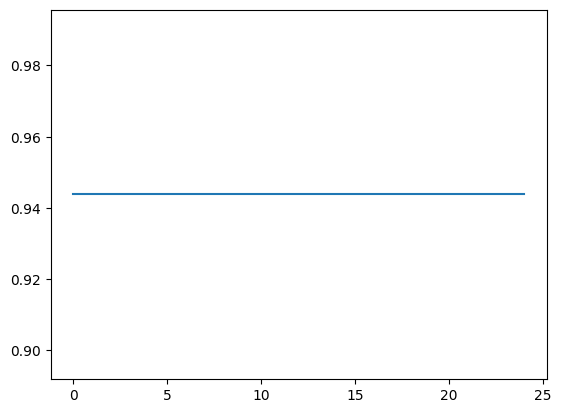

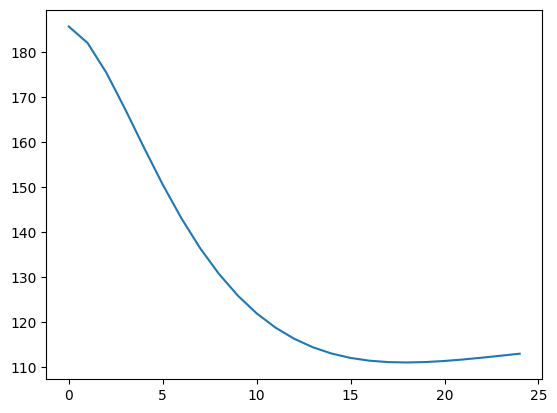

[2] loss: 394.062


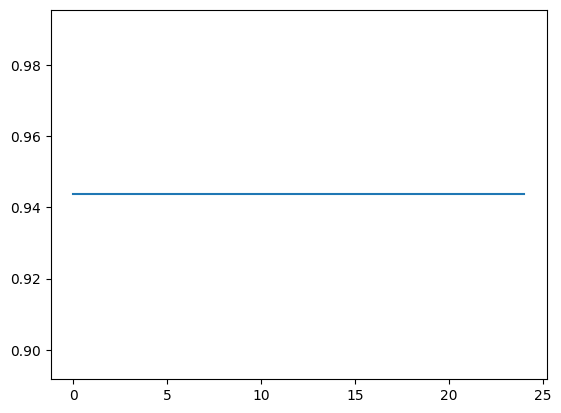

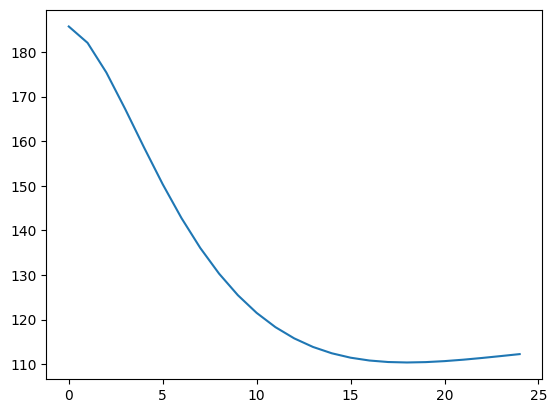

[3] loss: 364.554


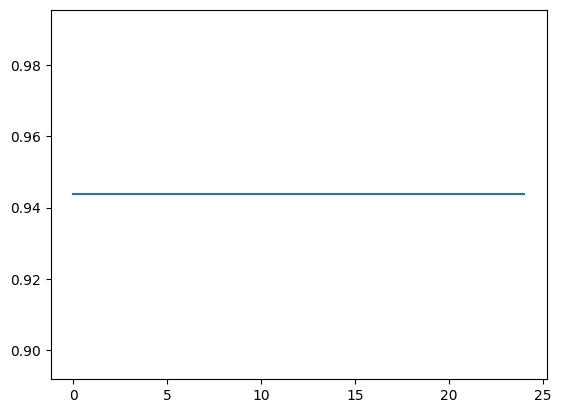

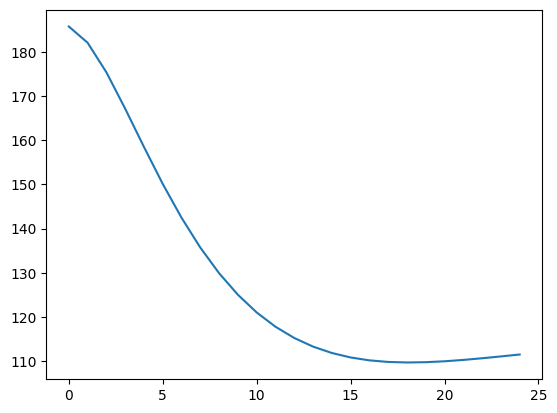

[4] loss: 333.726


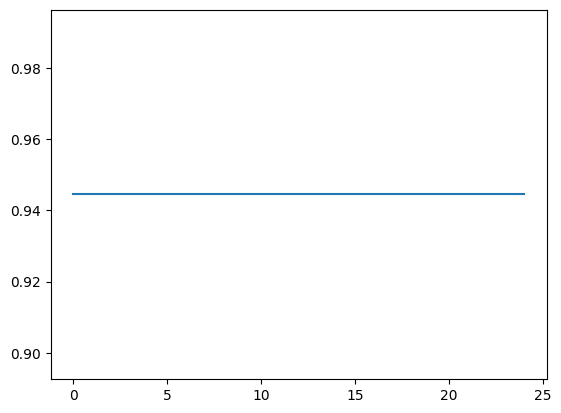

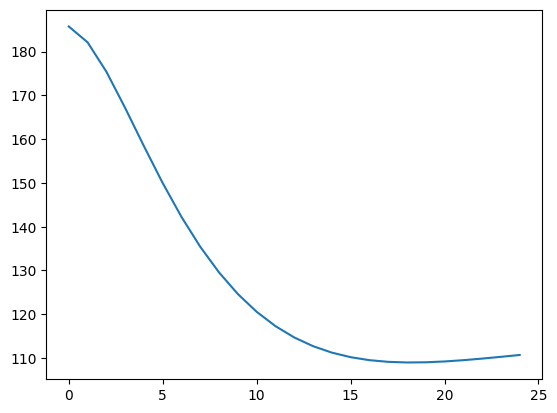

[5] loss: 289.670


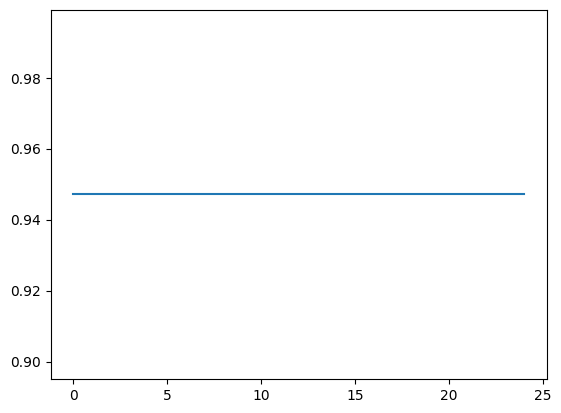

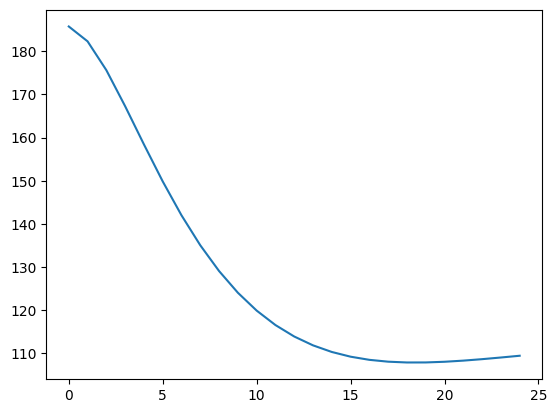

[6] loss: 237.585


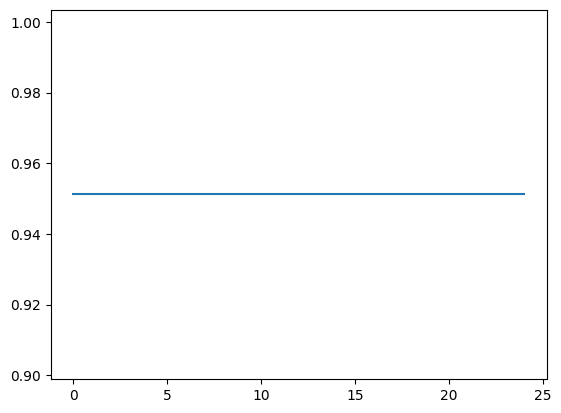

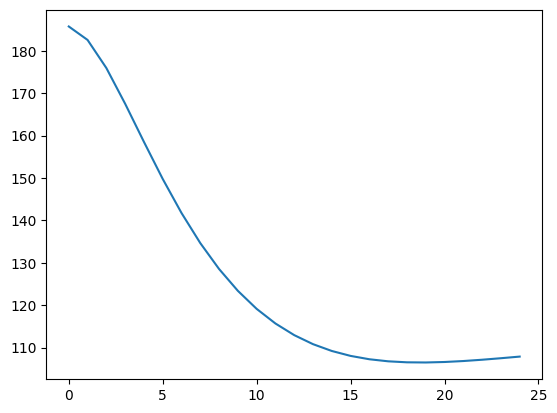

[7] loss: 197.606


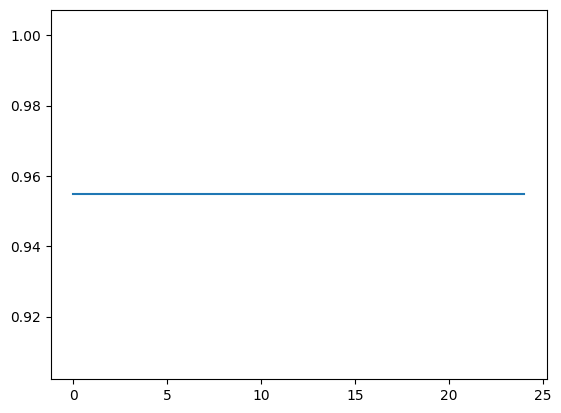

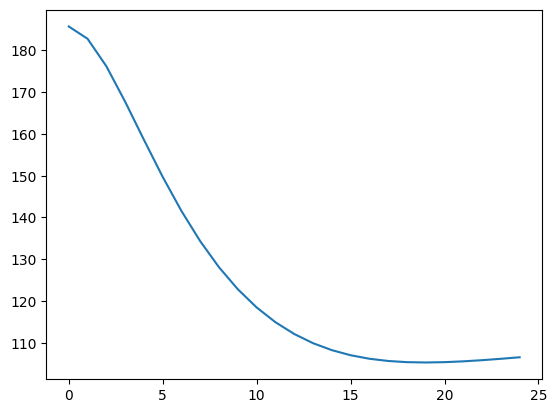

[8] loss: 168.574


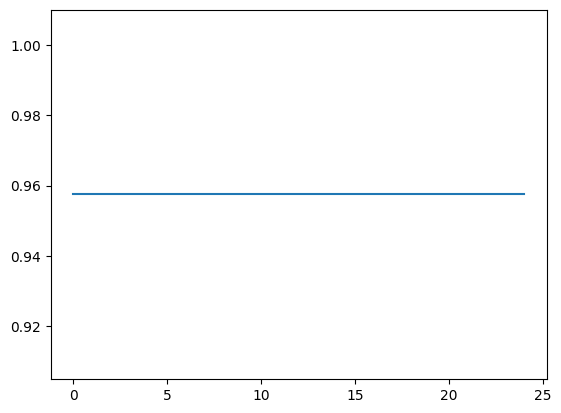

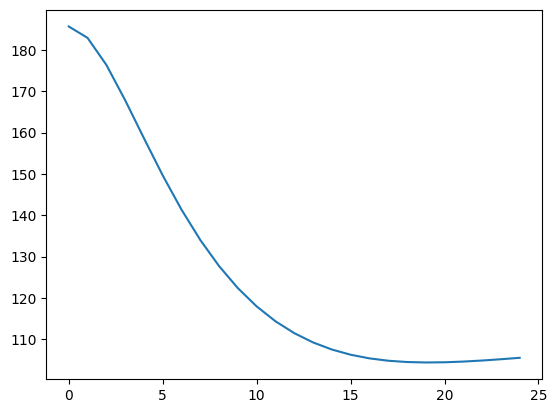

[9] loss: 146.056


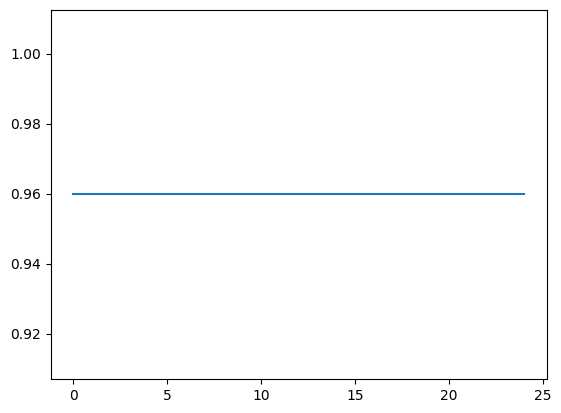

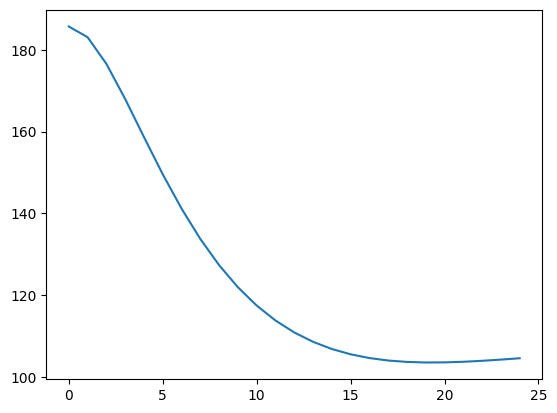

[10] loss: 125.796


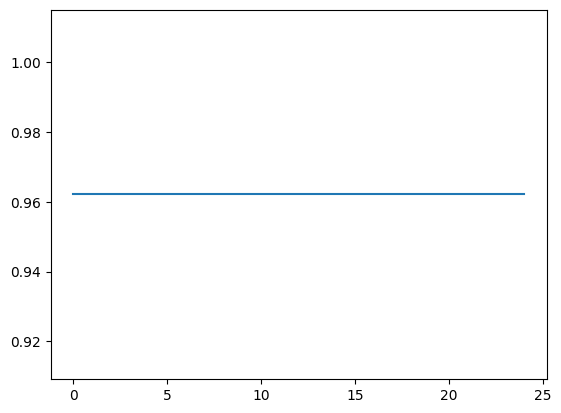

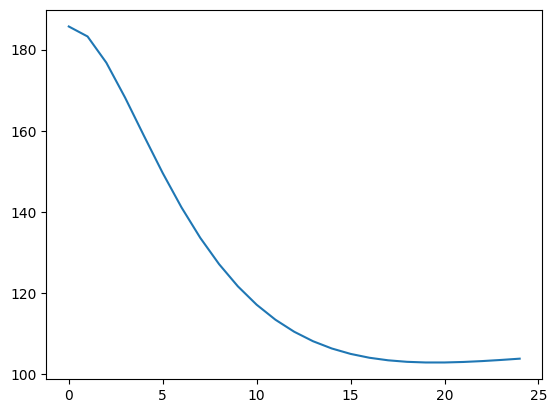

[11] loss: 103.806


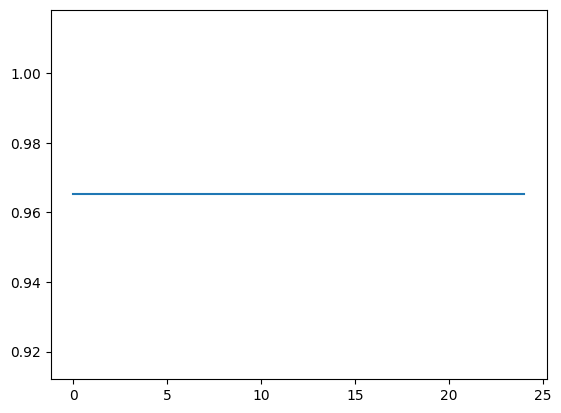

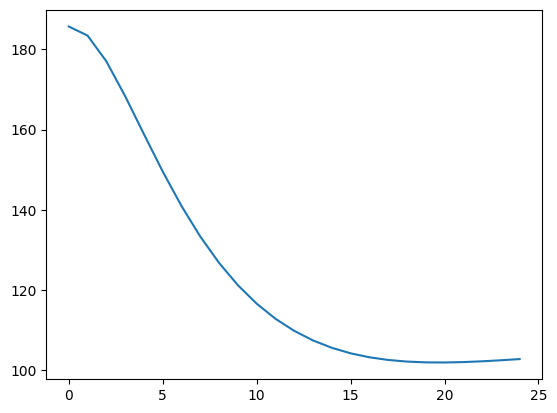

[12] loss: 84.043


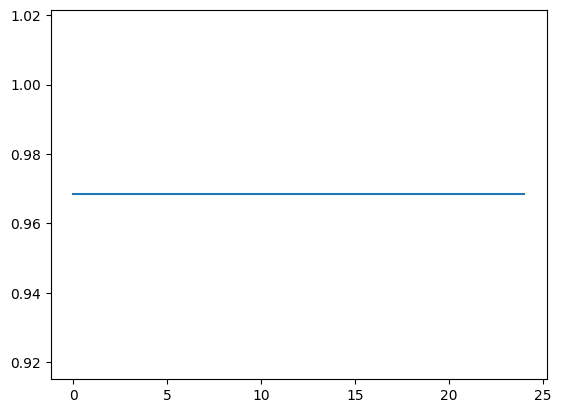

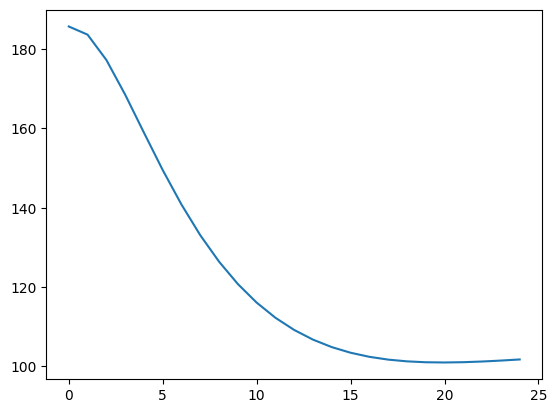

[13] loss: 69.555


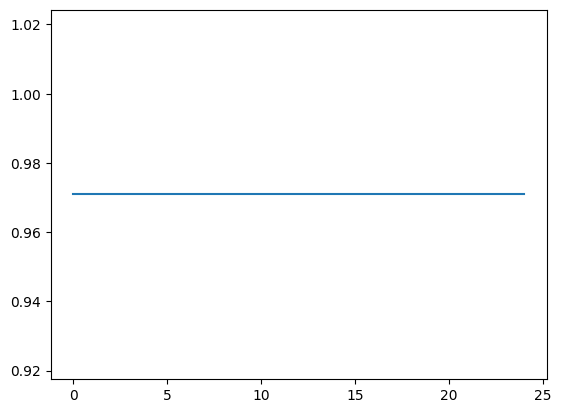

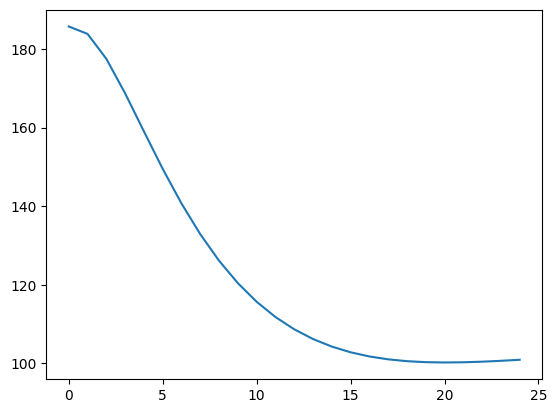

[14] loss: 58.873


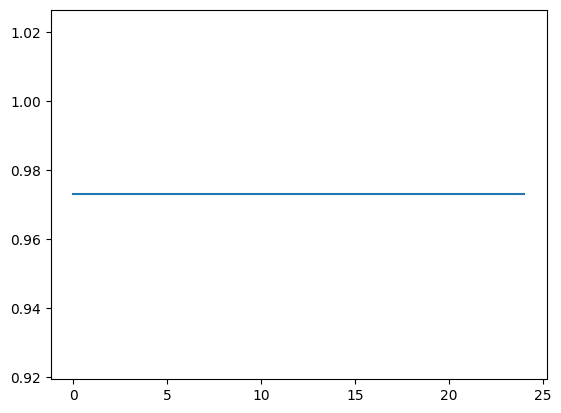

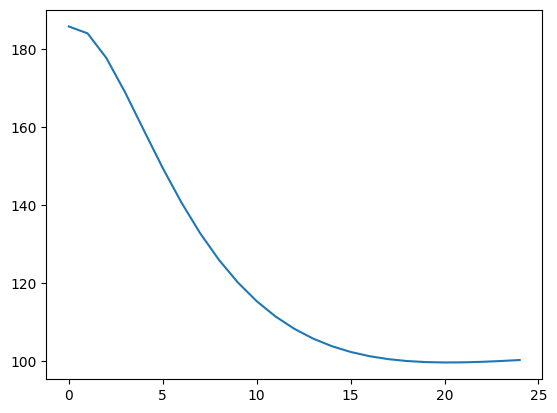

[15] loss: 50.547


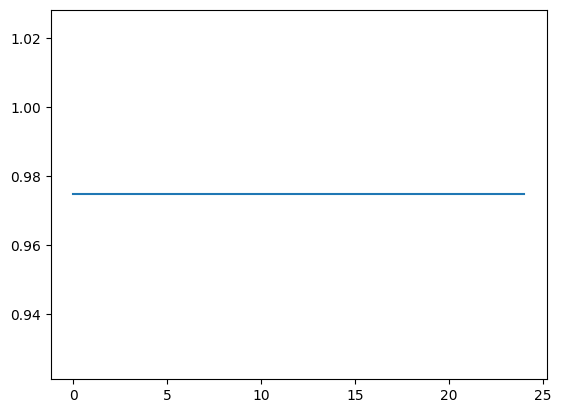

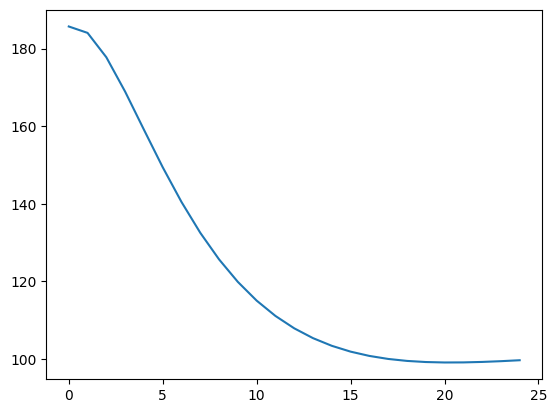

[16] loss: 43.379


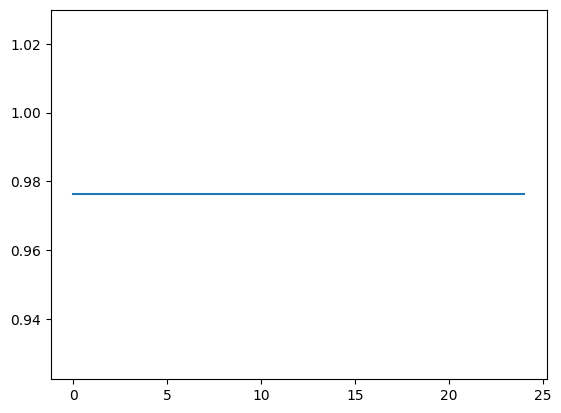

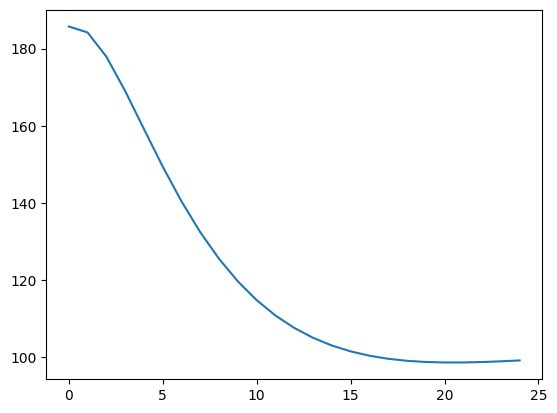

[17] loss: 36.312


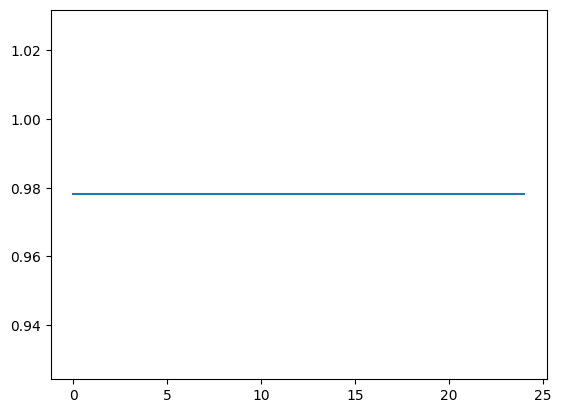

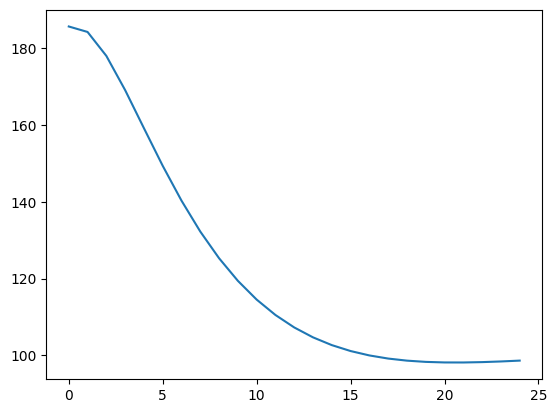

[18] loss: 29.792


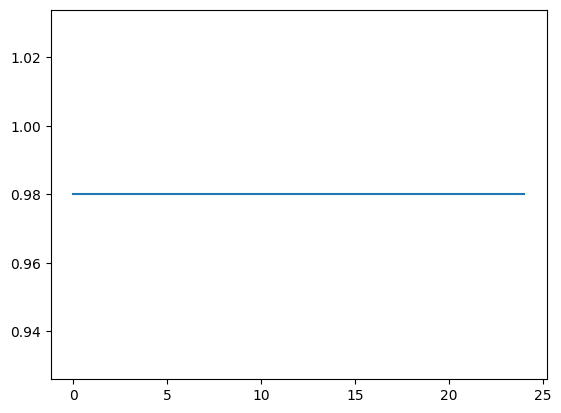

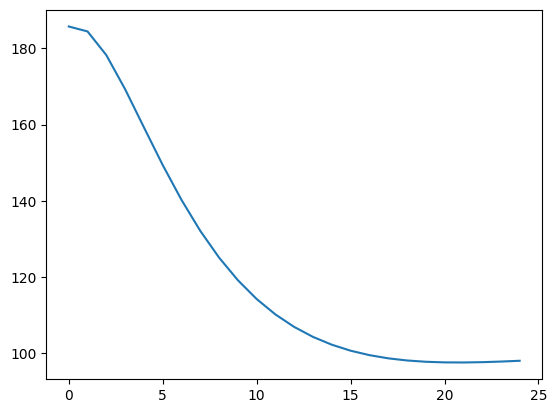

[19] loss: 24.676


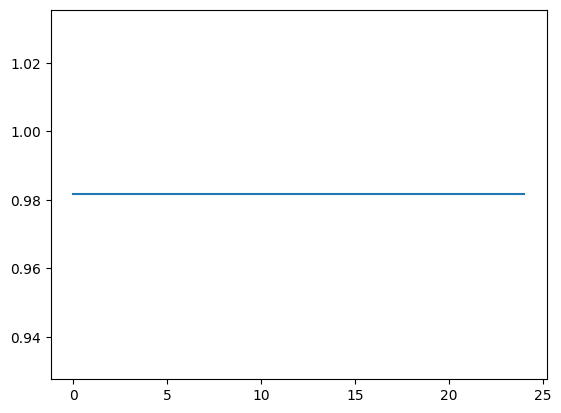

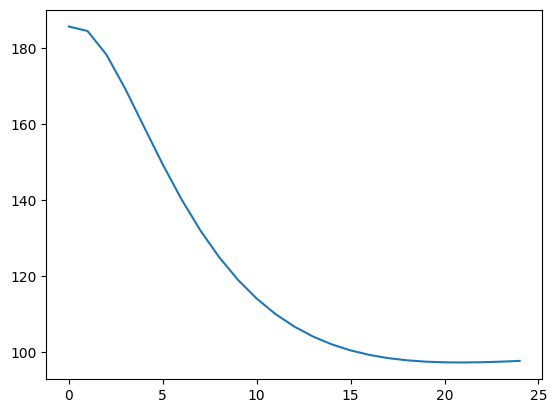

[20] loss: 20.790


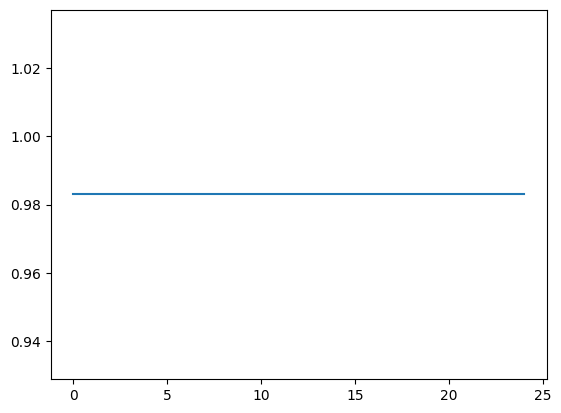

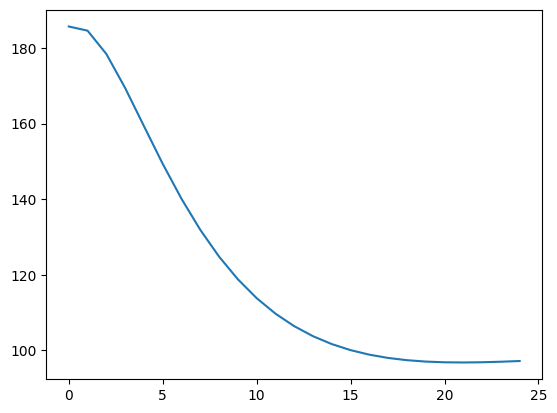

[21] loss: 17.738


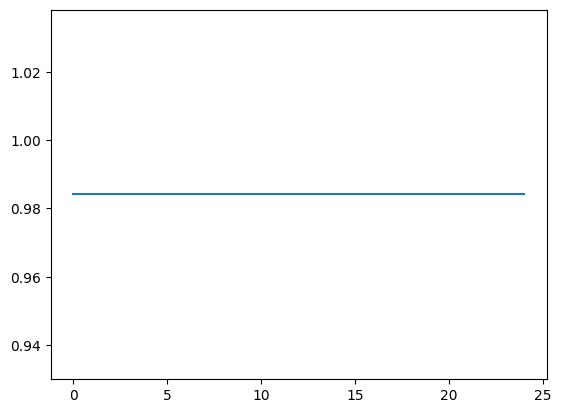

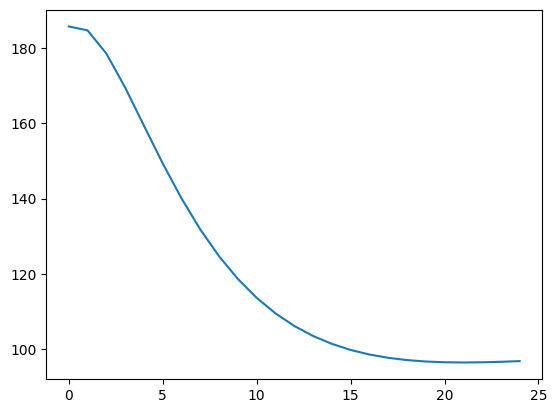

[22] loss: 15.167


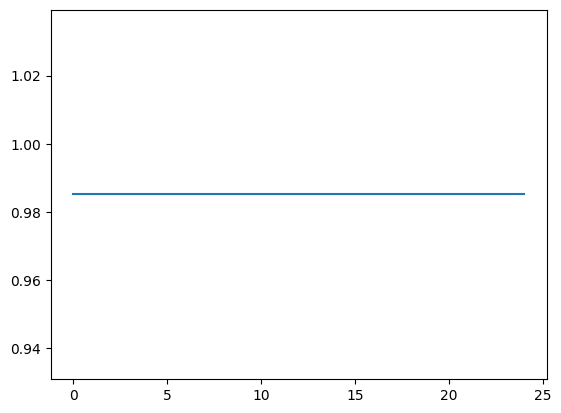

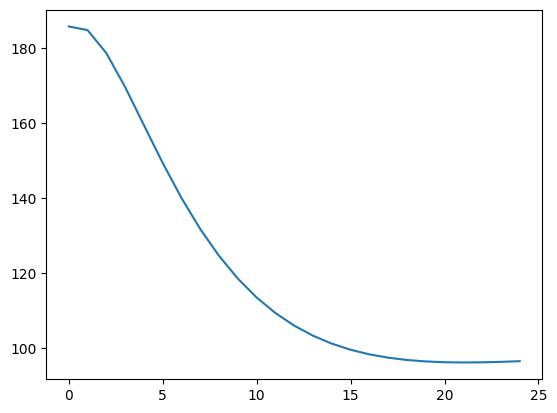

[23] loss: 12.781


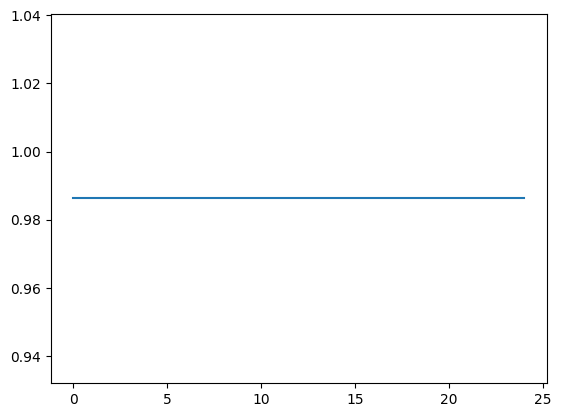

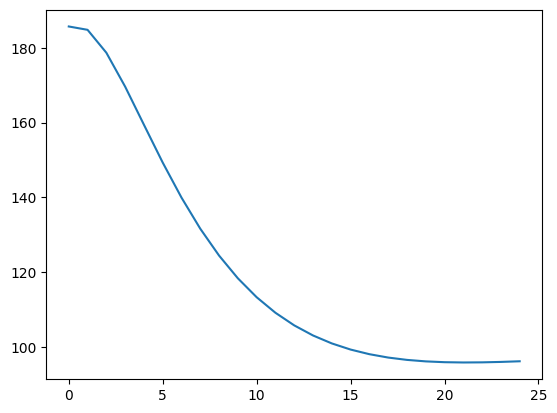

[24] loss: 10.589


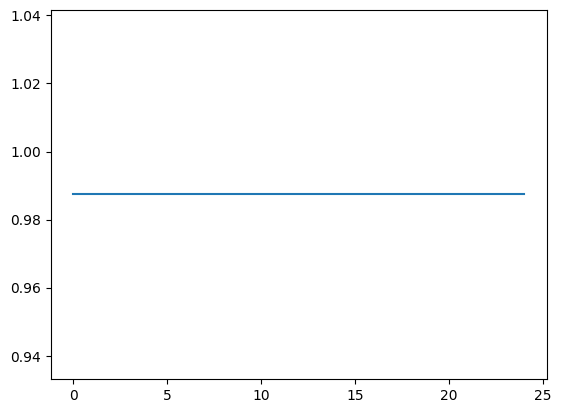

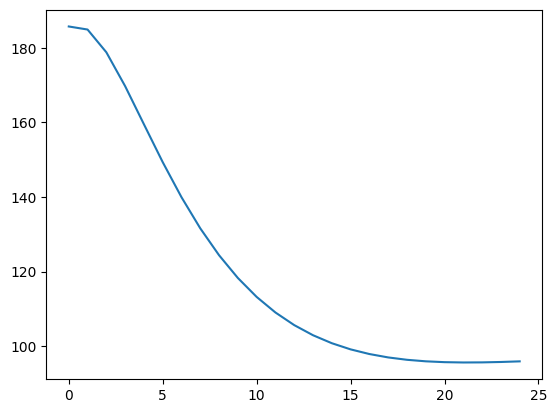

[25] loss: 8.786


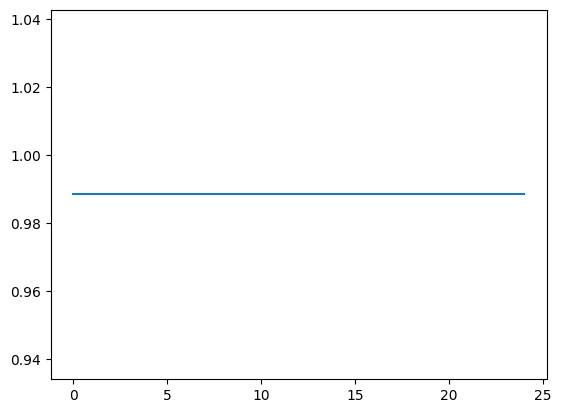

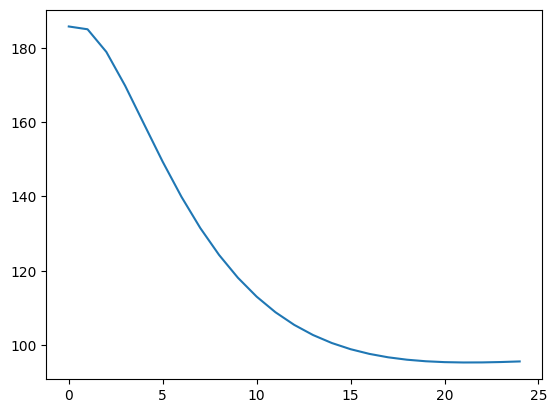

[26] loss: 7.379


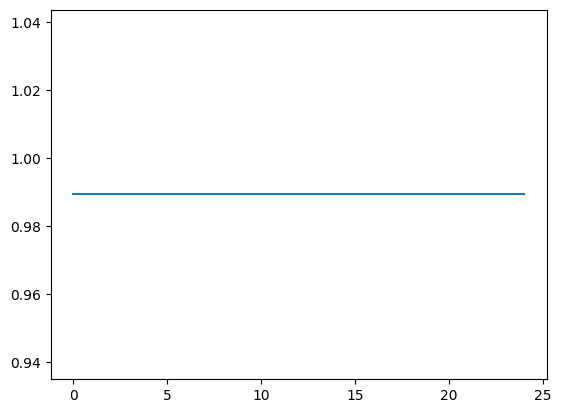

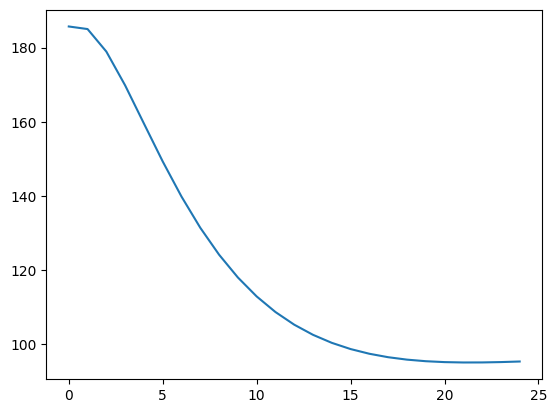

[27] loss: 6.264


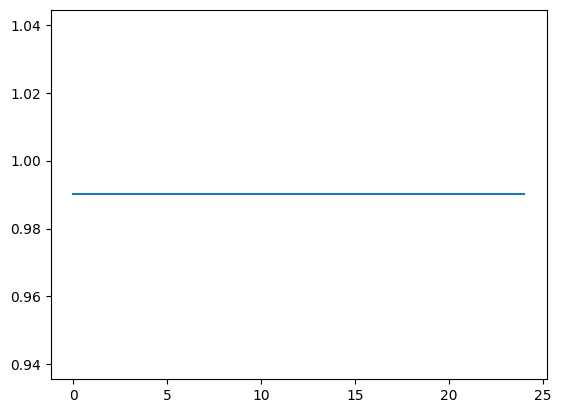

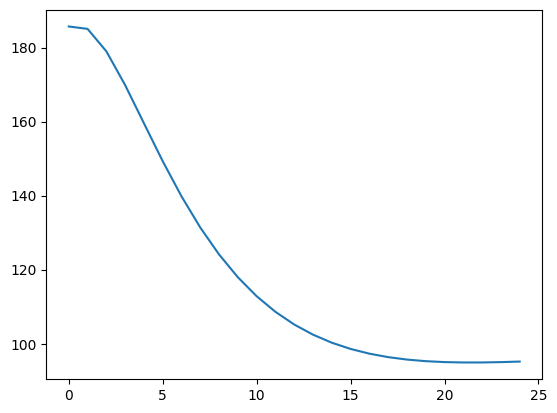

[28] loss: 5.336


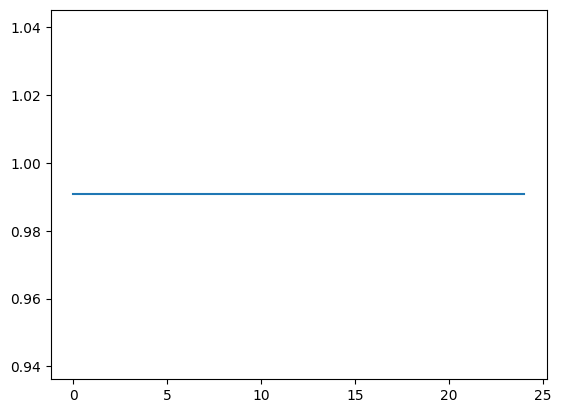

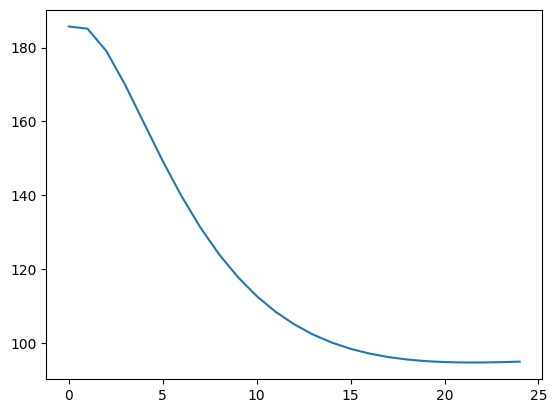

[29] loss: 4.508


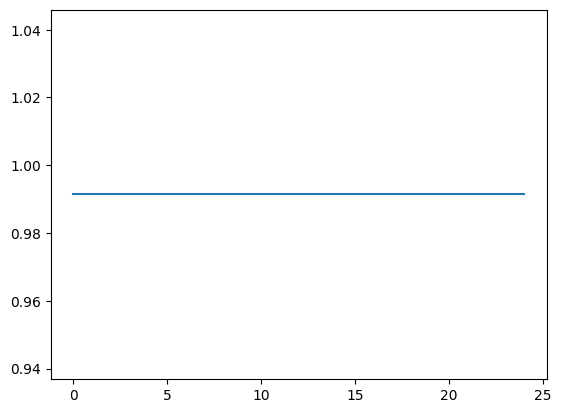

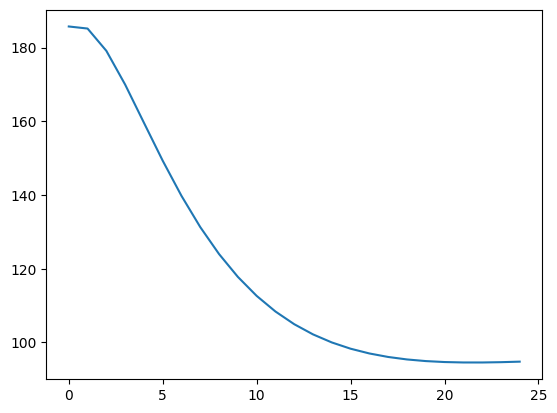

[30] loss: 3.760


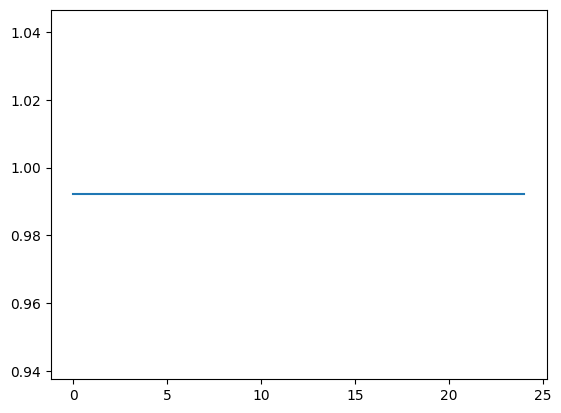

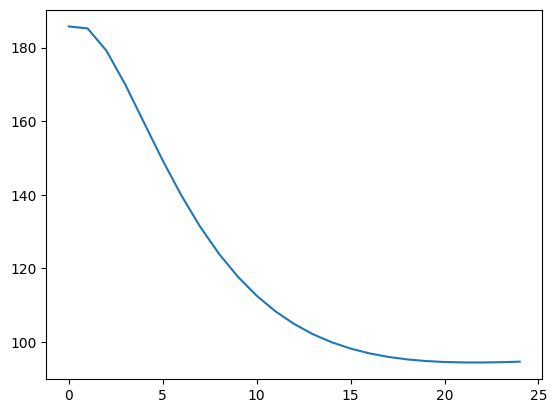

[31] loss: 3.128


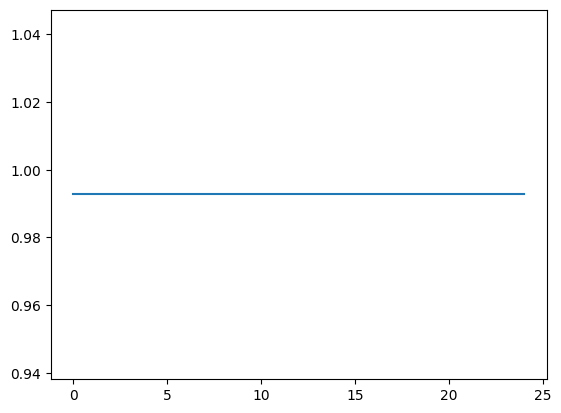

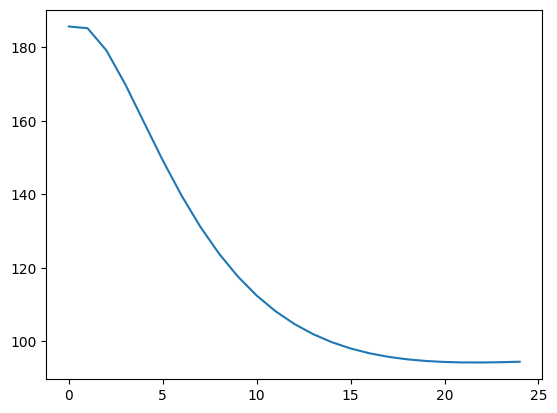

[32] loss: 2.621


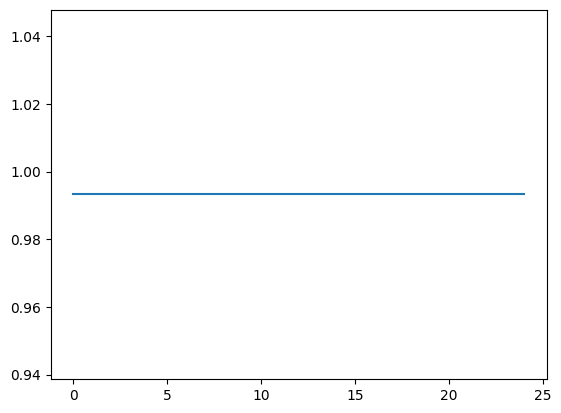

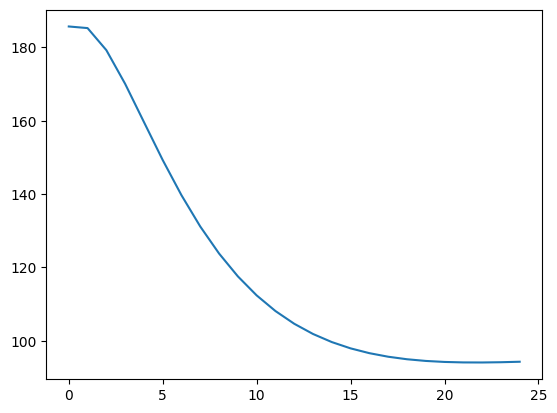

[33] loss: 2.216


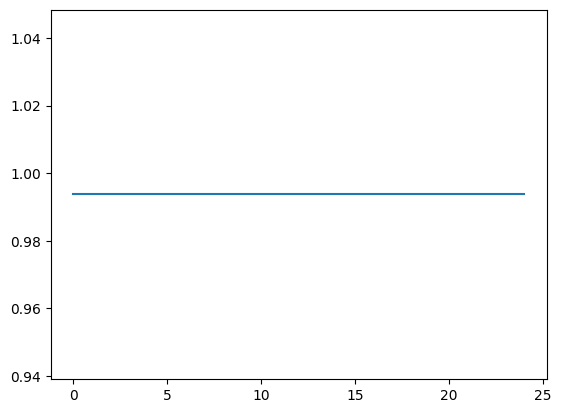

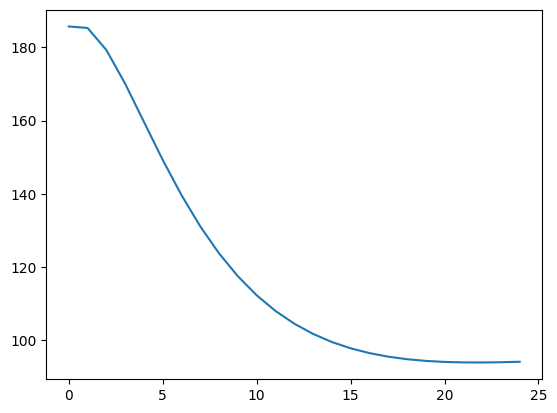

[34] loss: 1.882


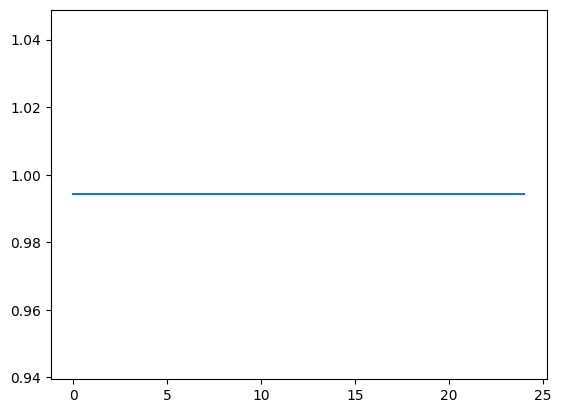

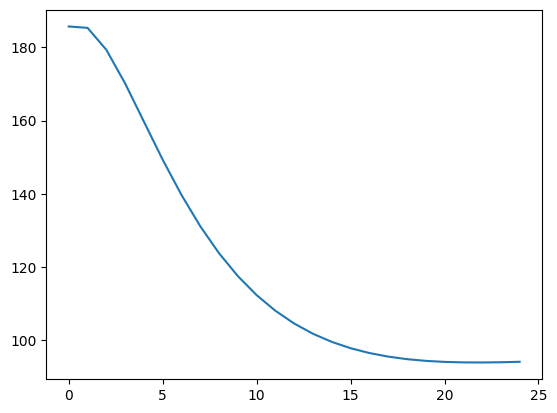

[35] loss: 1.591


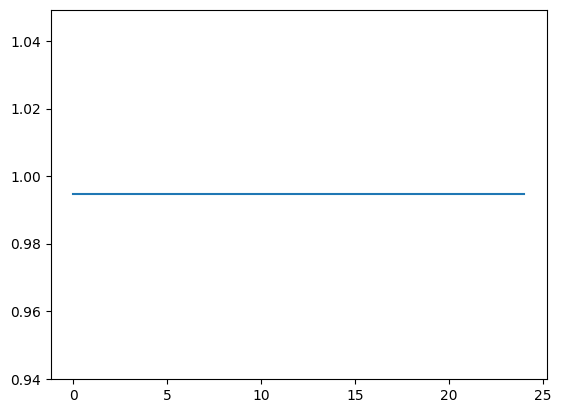

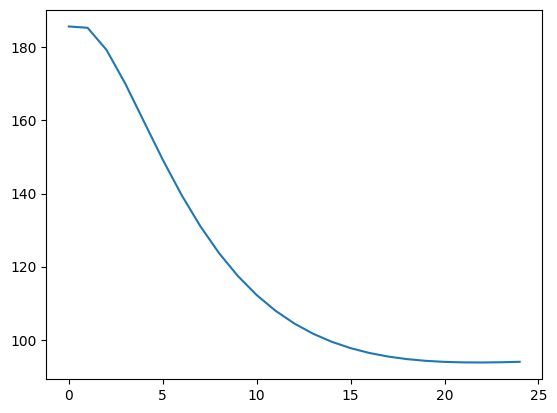

[36] loss: 1.332


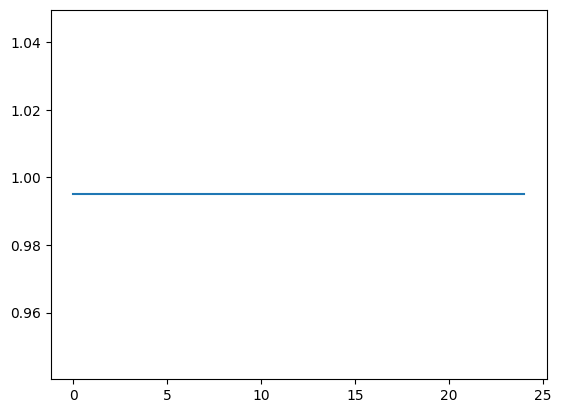

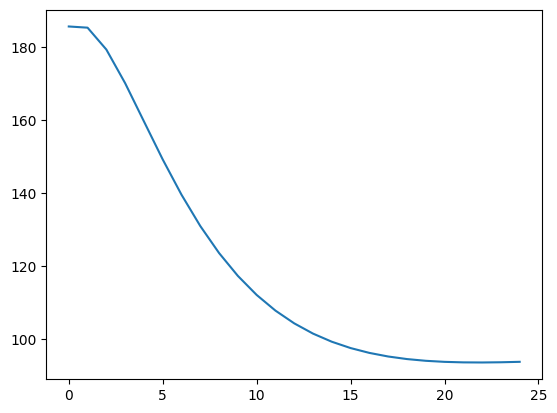

[37] loss: 1.111


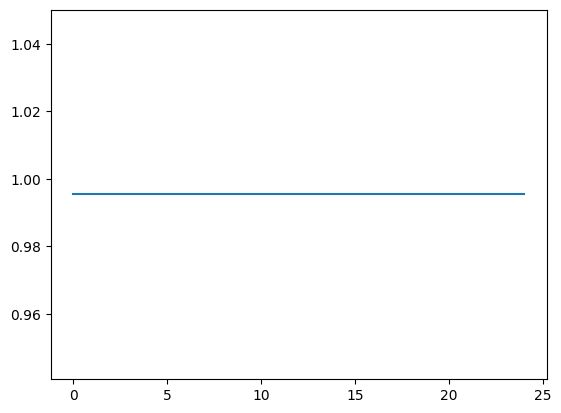

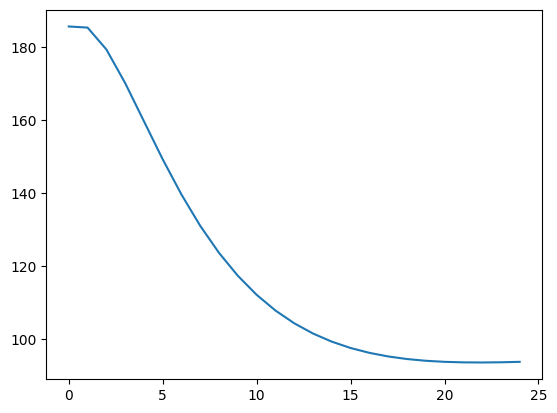

[38] loss: 0.929


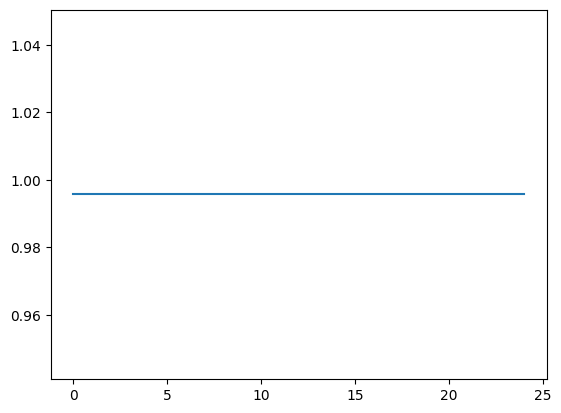

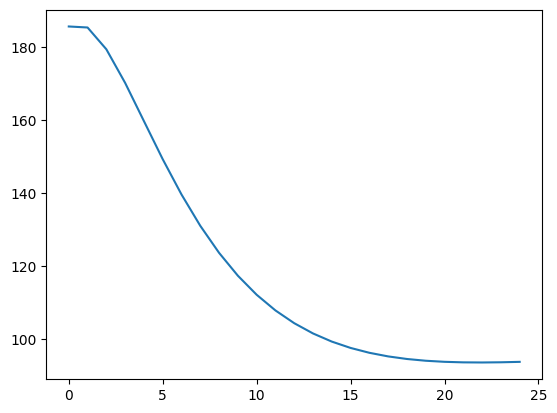

[39] loss: 0.783


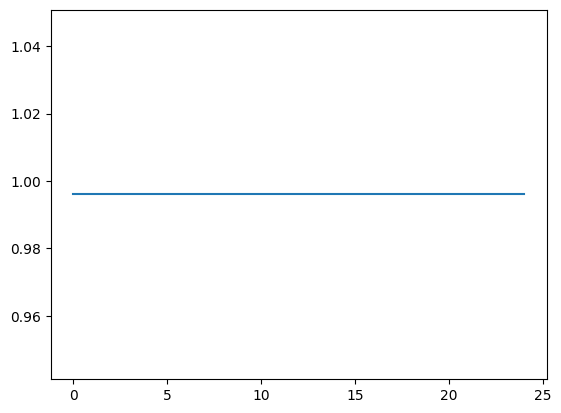

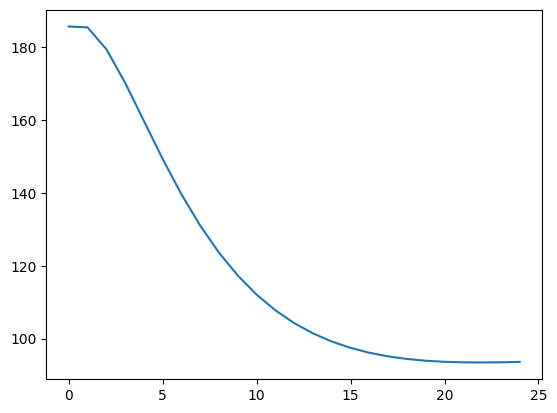

[40] loss: 0.663


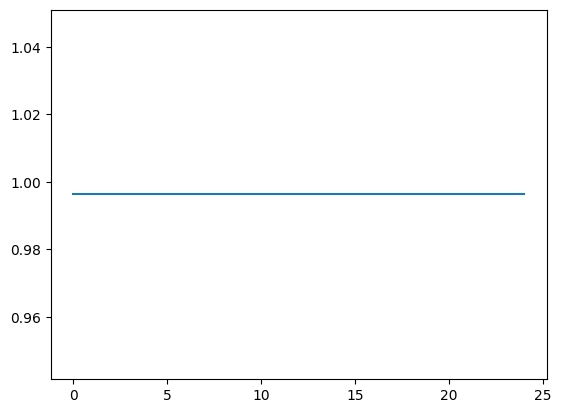

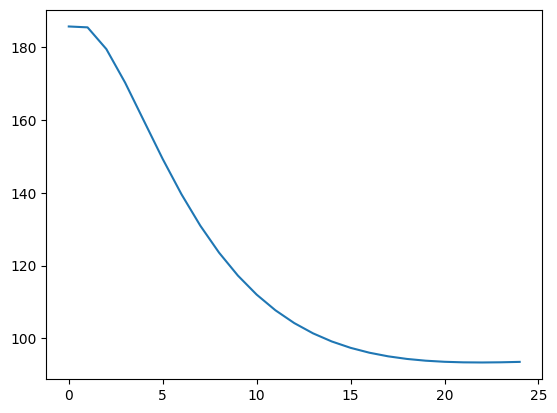

[41] loss: 0.560


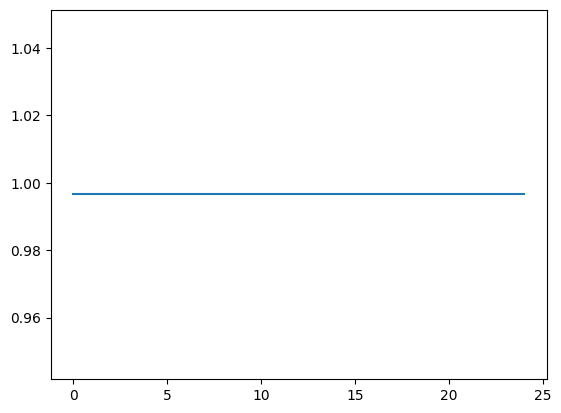

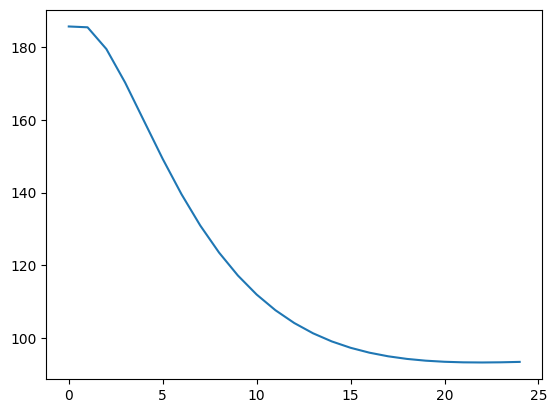

[42] loss: 0.470


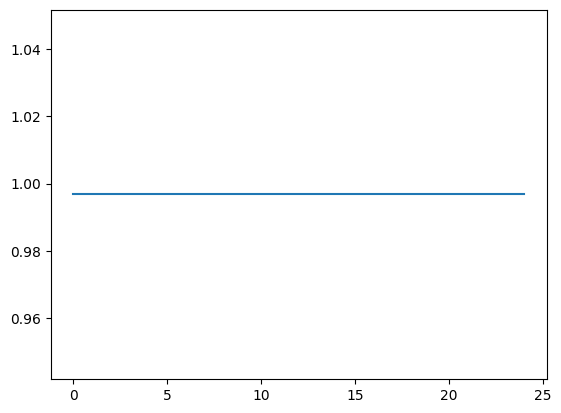

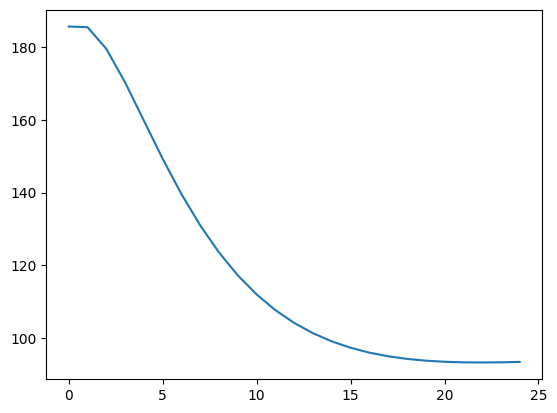

[43] loss: 0.393


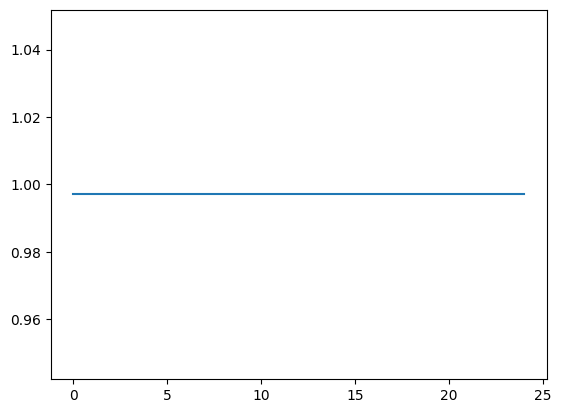

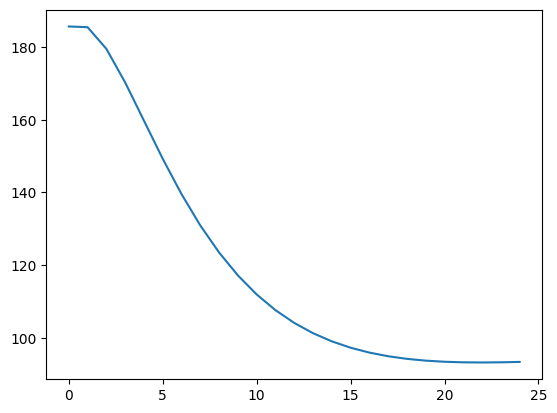

[44] loss: 0.328


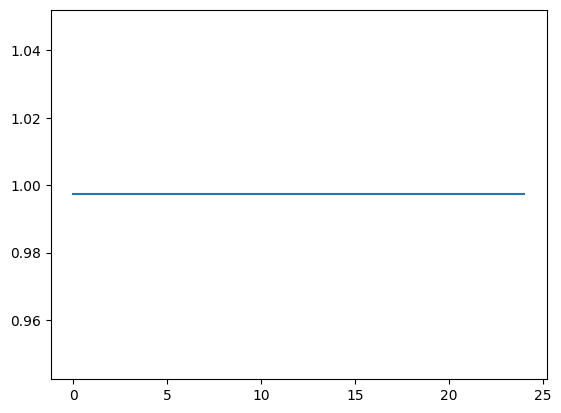

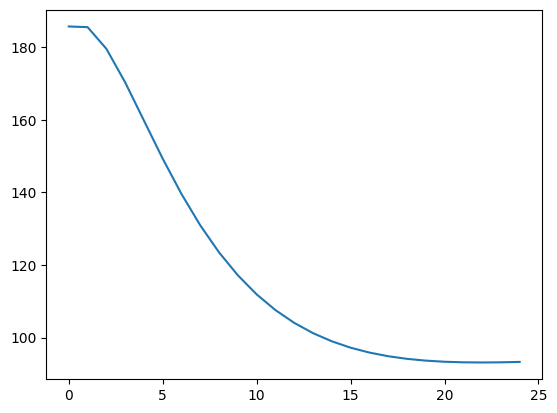

[45] loss: 0.276


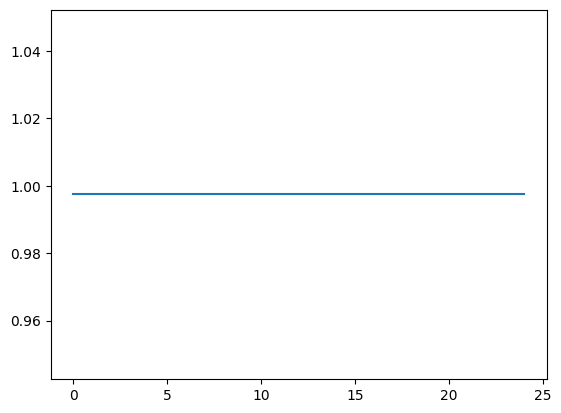

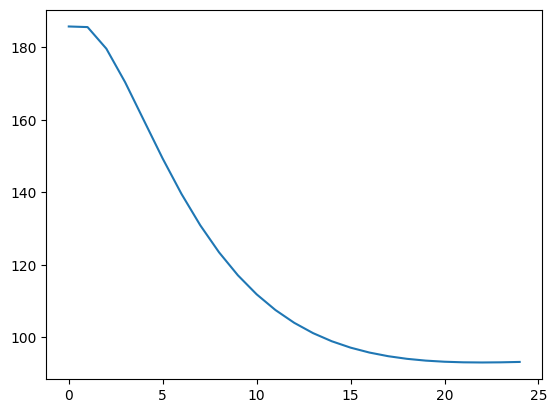

[46] loss: 0.233


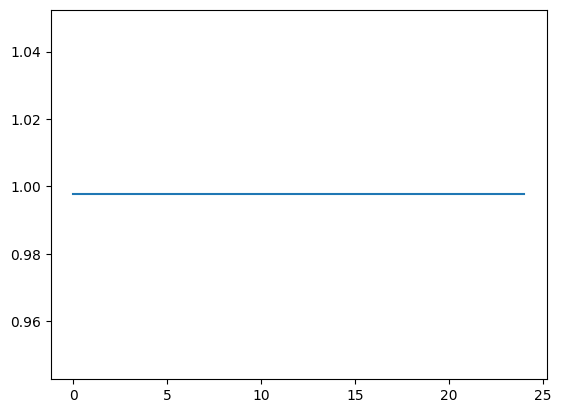

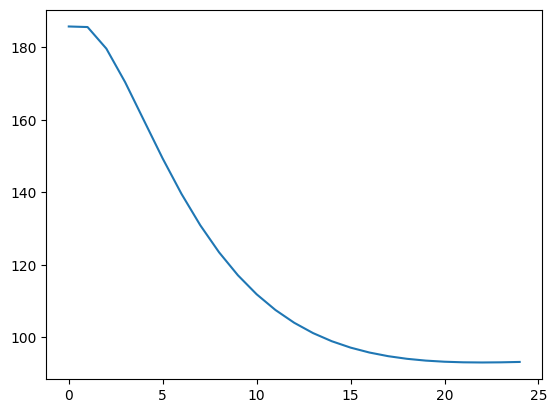

[47] loss: 0.196


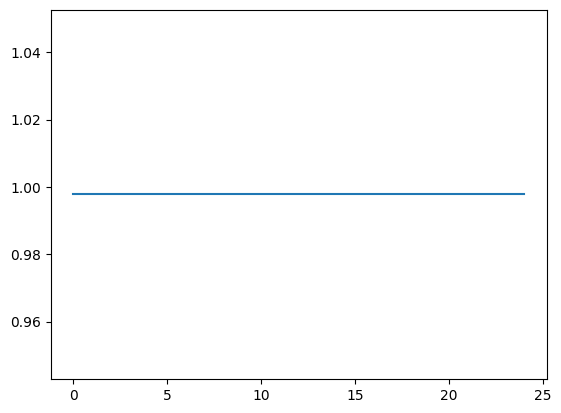

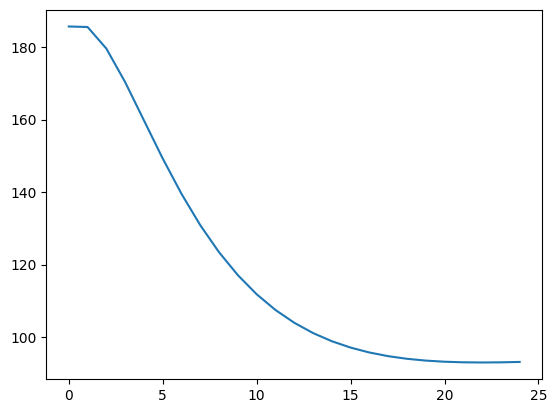

[48] loss: 0.165


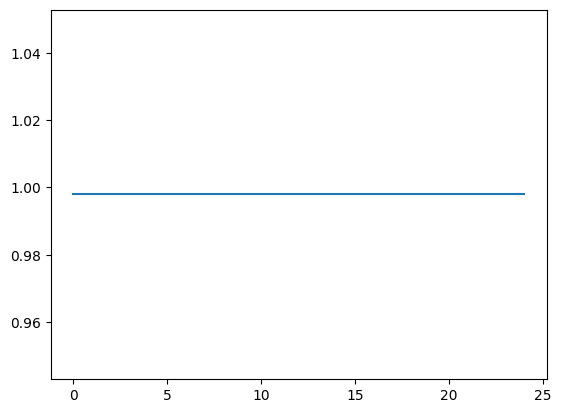

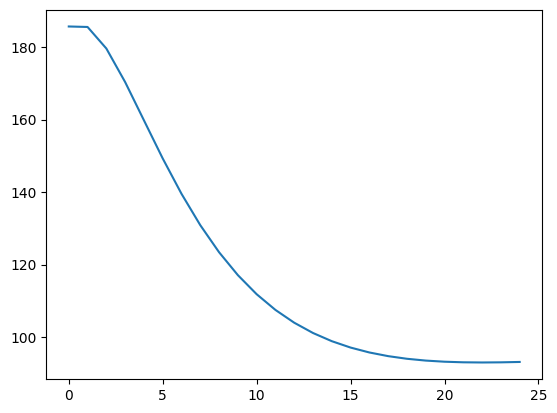

[49] loss: 0.138


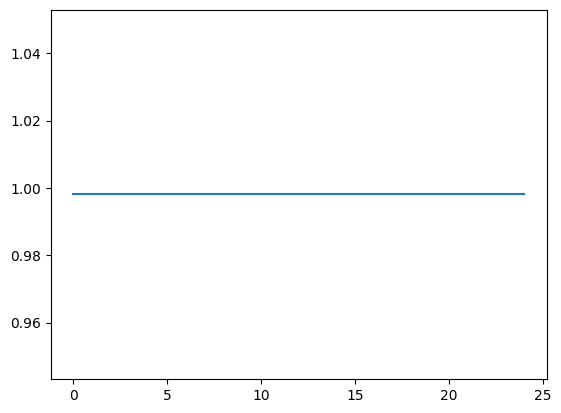

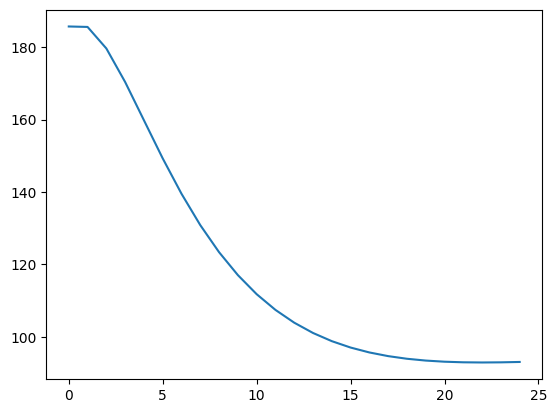

[50] loss: 0.115


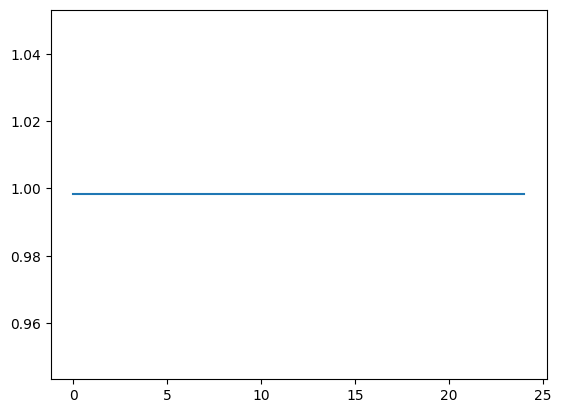

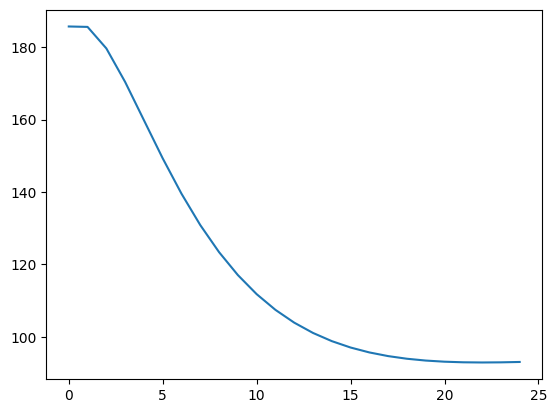

[51] loss: 0.097


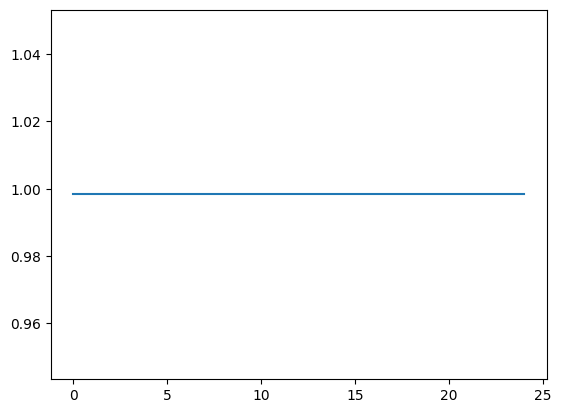

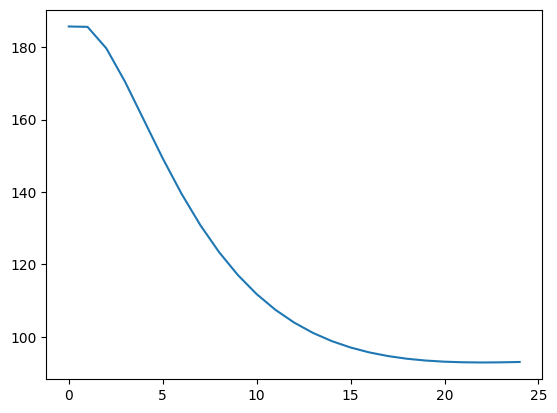

[52] loss: 0.081


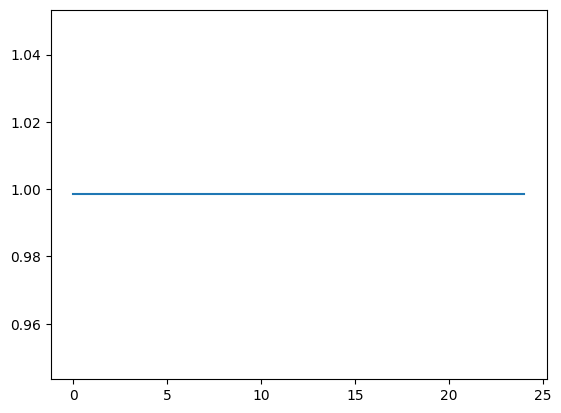

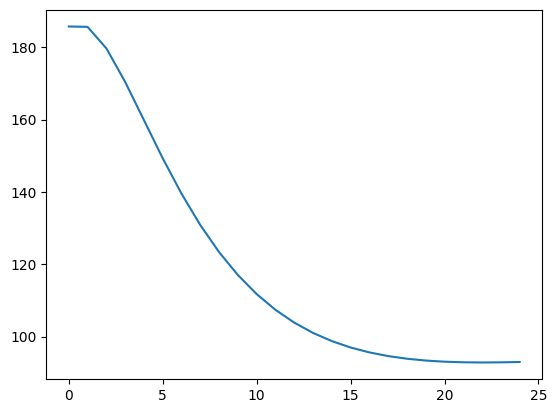

[53] loss: 0.068


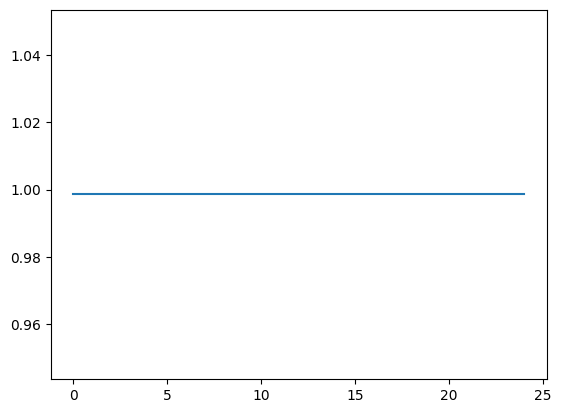

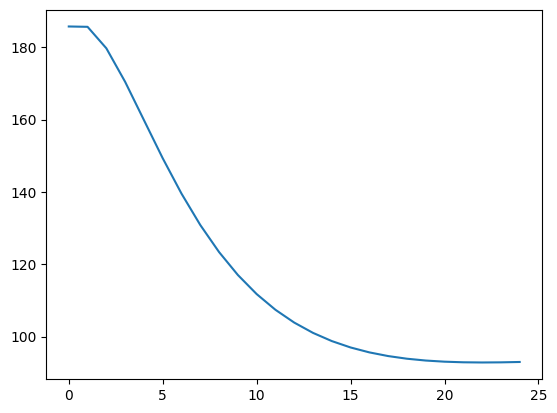

[54] loss: 0.058


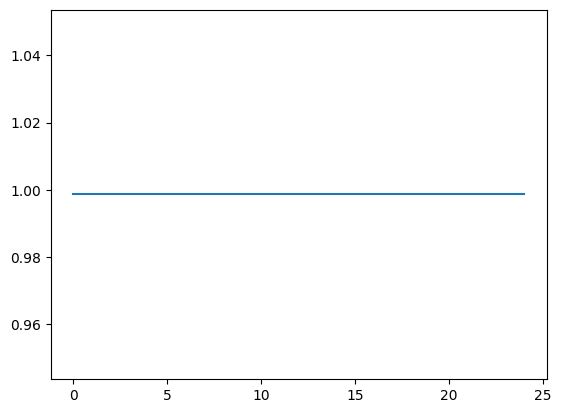

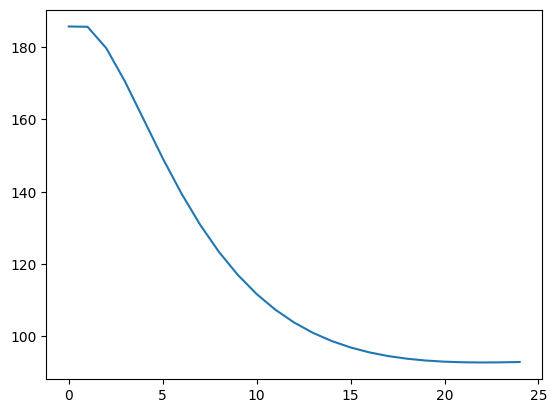

[55] loss: 0.048


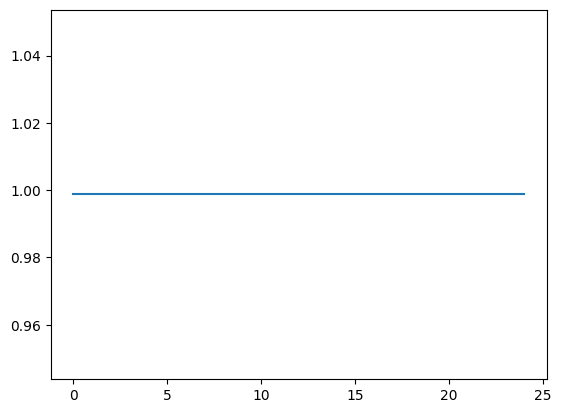

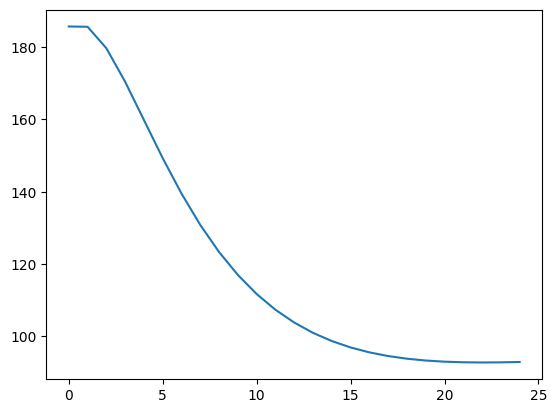

[56] loss: 0.040


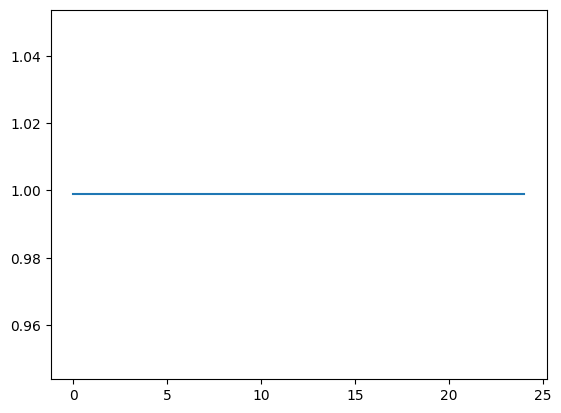

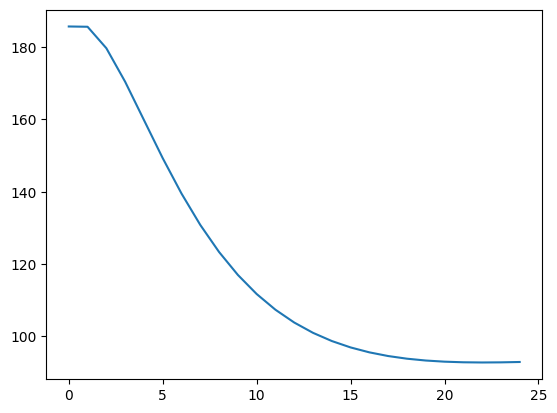

[57] loss: 0.034


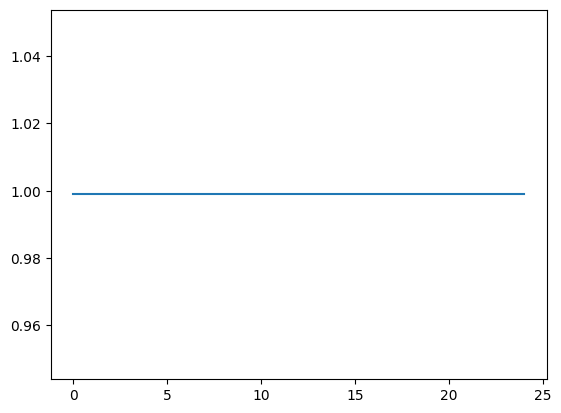

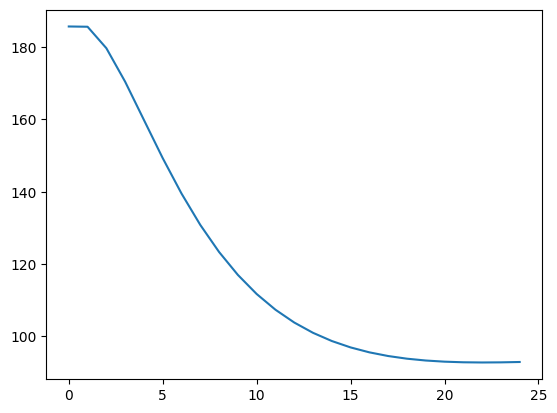

[58] loss: 0.028


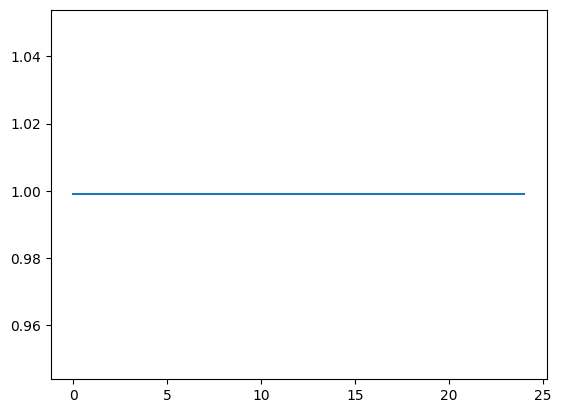

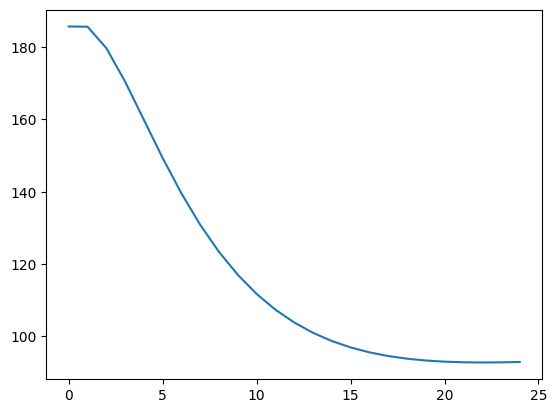

[59] loss: 0.024


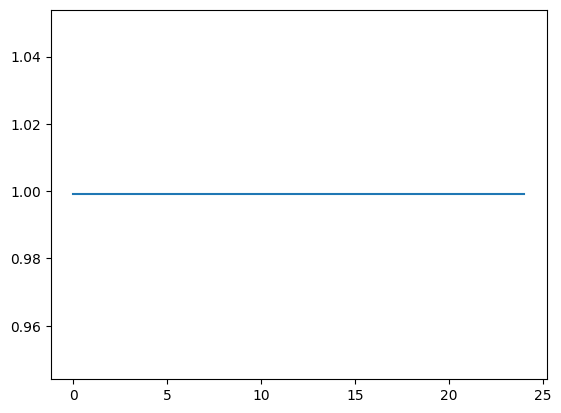

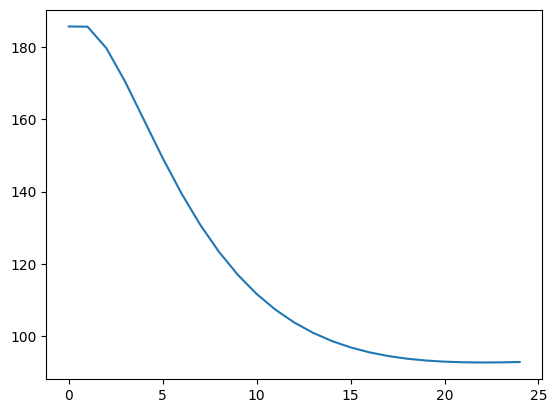

[60] loss: 0.020


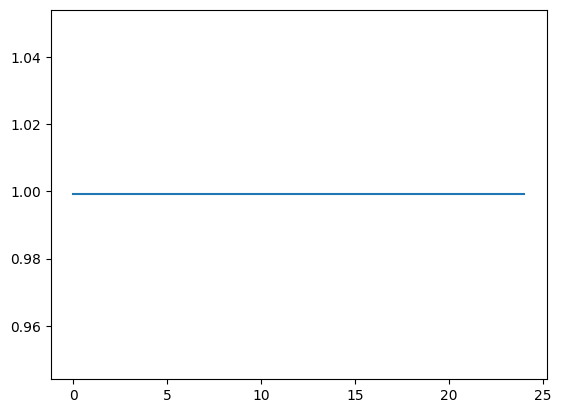

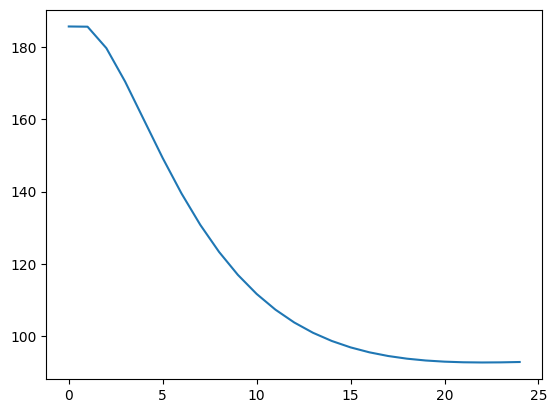

[61] loss: 0.016


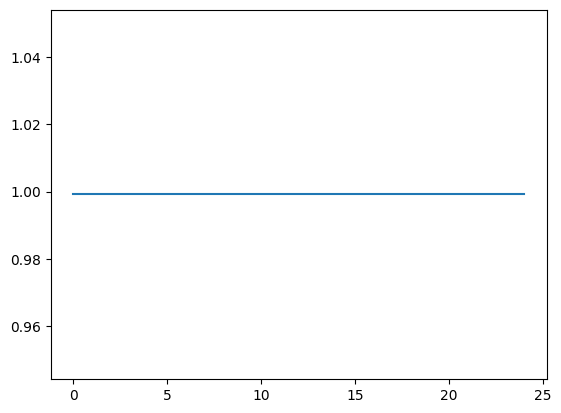

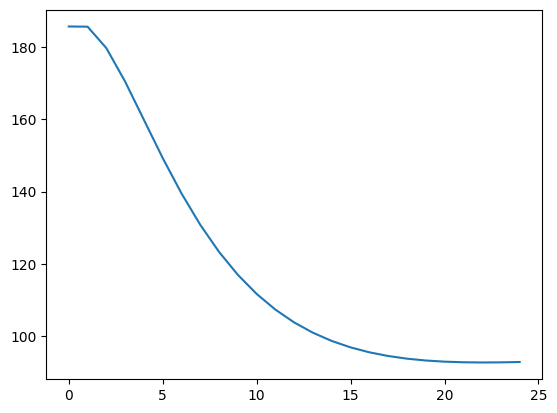

[62] loss: 0.014


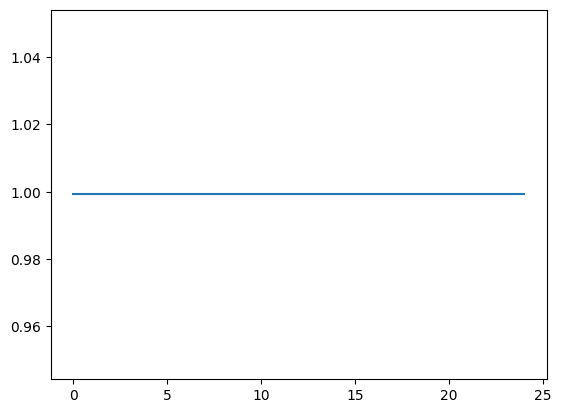

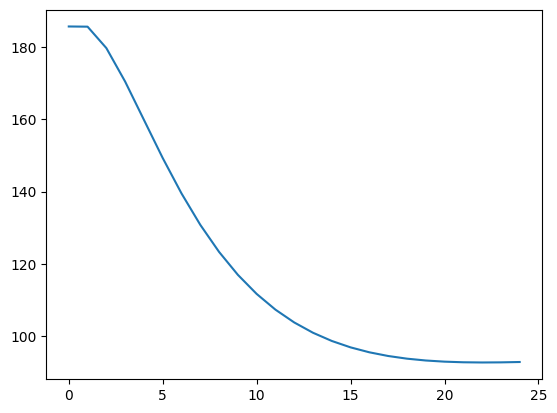

[63] loss: 0.011


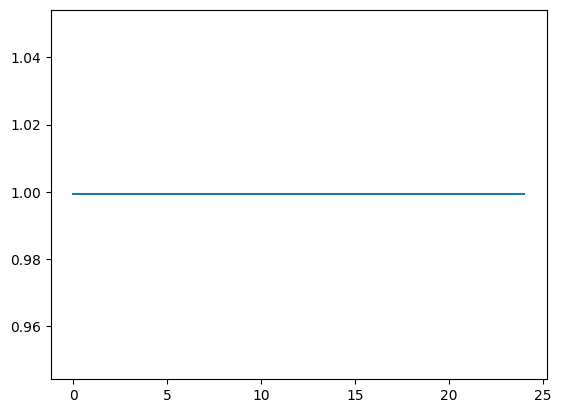

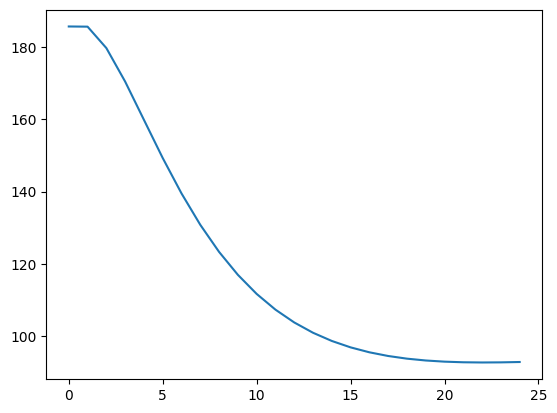

[64] loss: 0.010


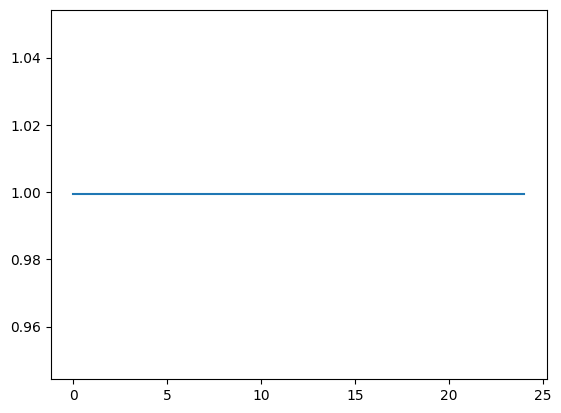

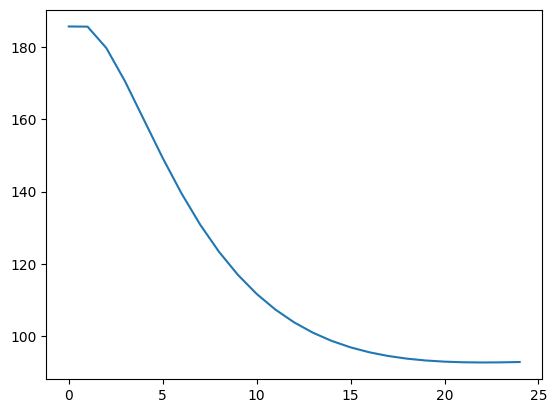

[65] loss: 0.008


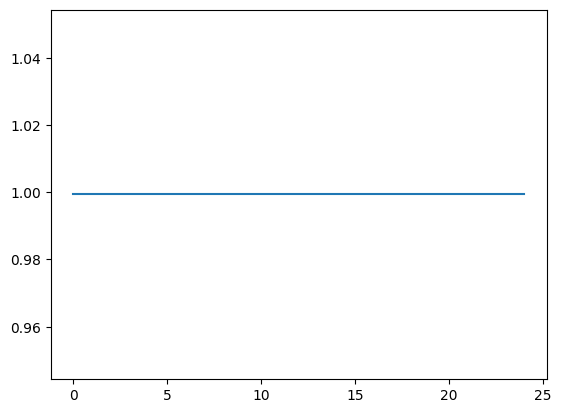

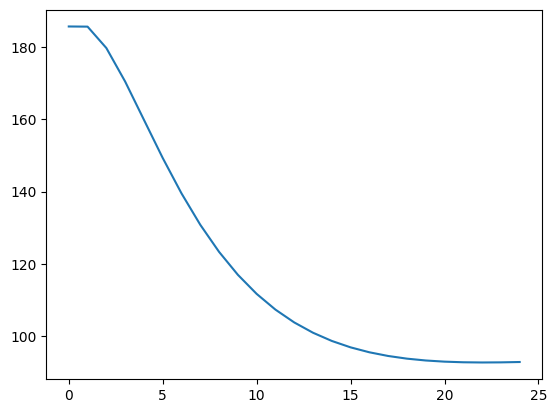

[66] loss: 0.007


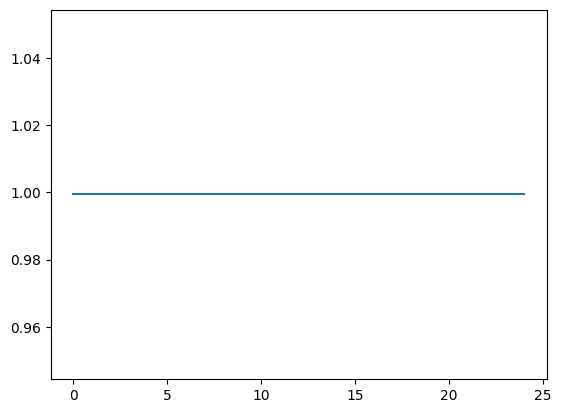

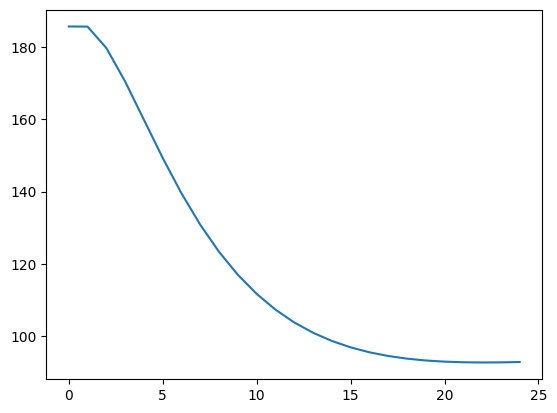

[67] loss: 0.006


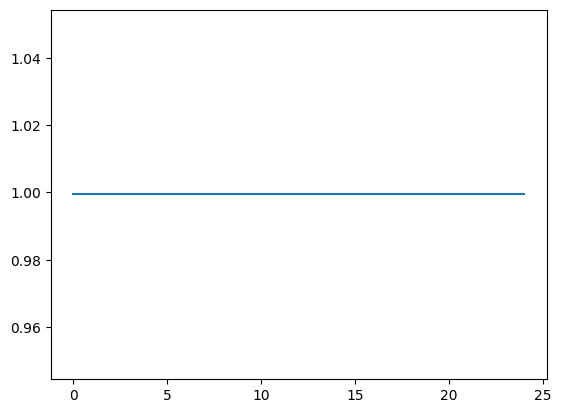

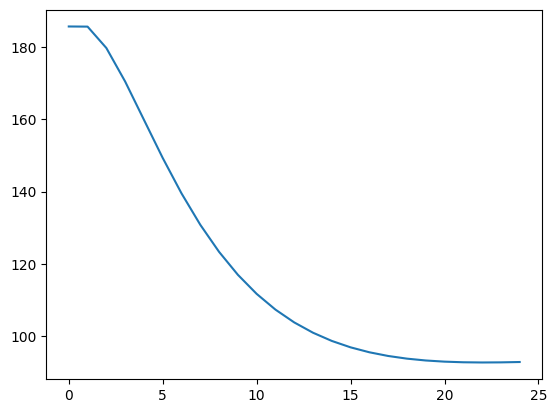

[68] loss: 0.005


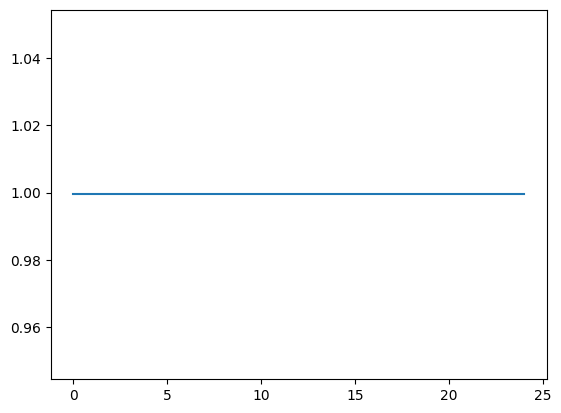

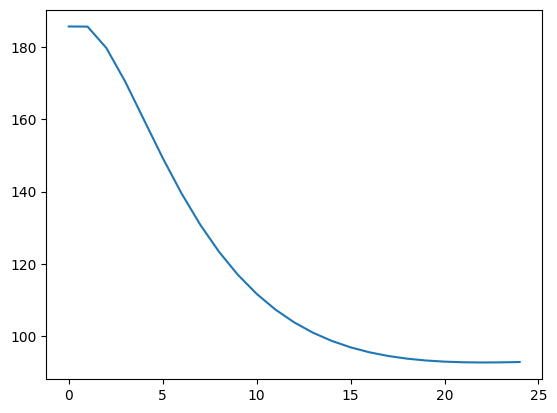

[69] loss: 0.004


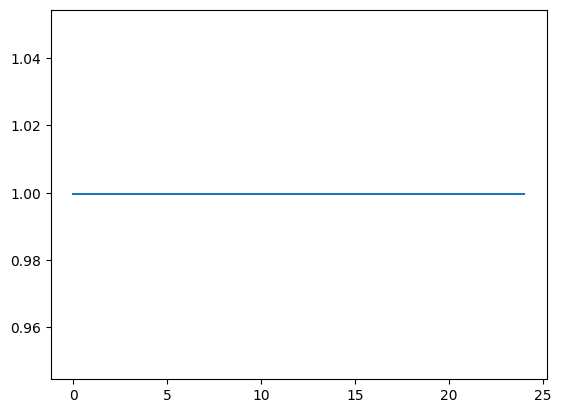

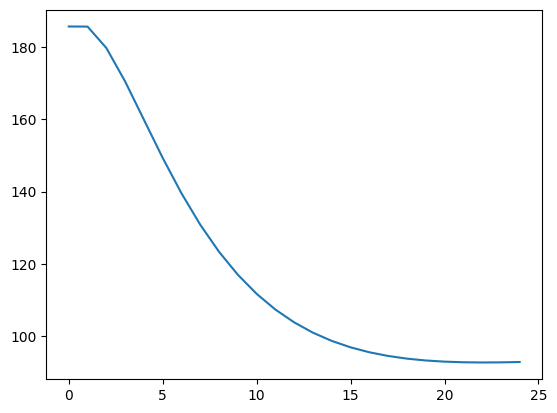

[70] loss: 0.003


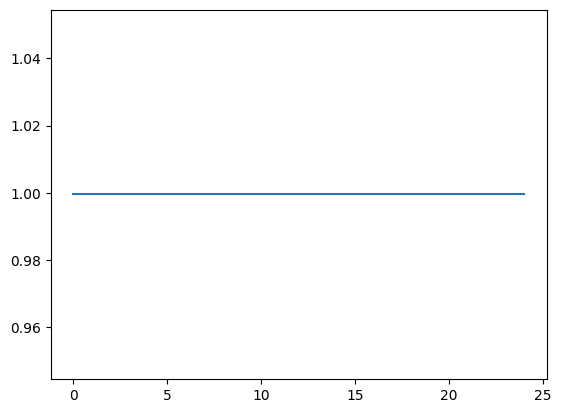

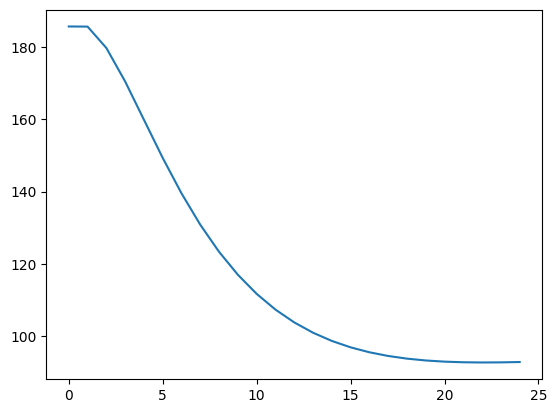

[71] loss: 0.003


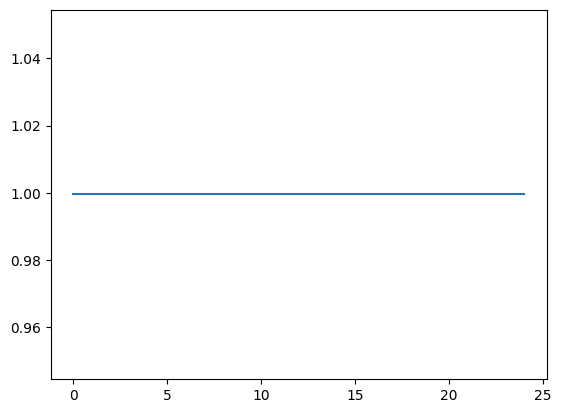

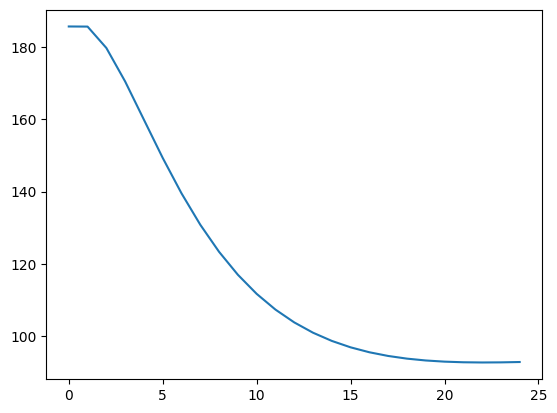

[72] loss: 0.002


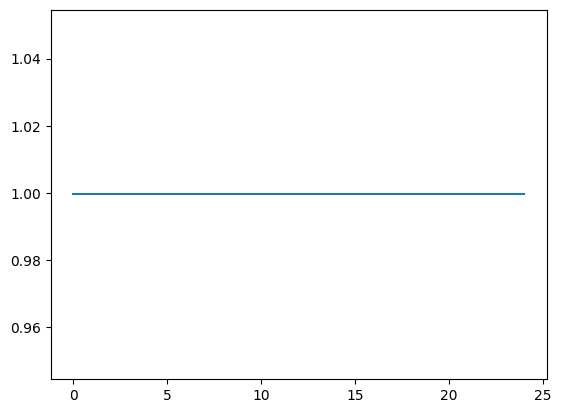

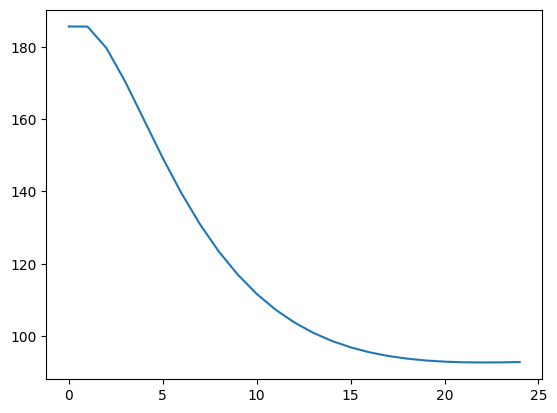

[73] loss: 0.002


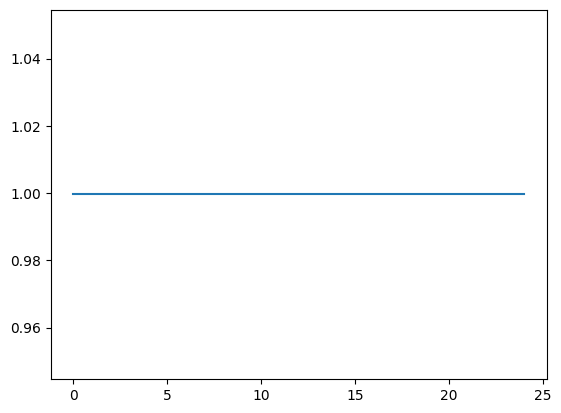

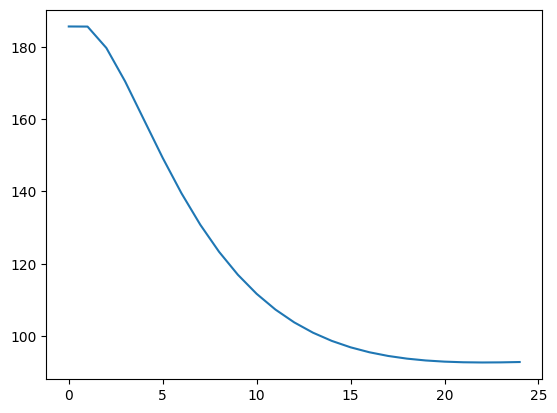

[74] loss: 0.001


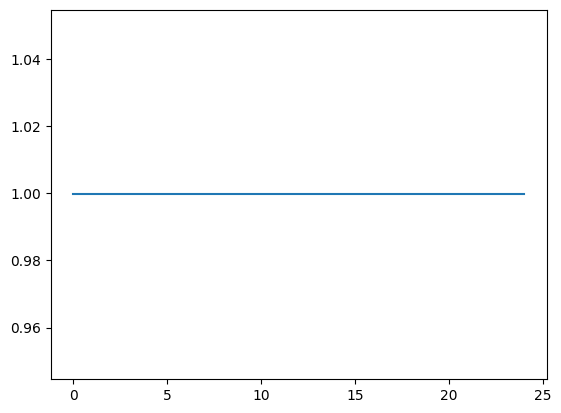

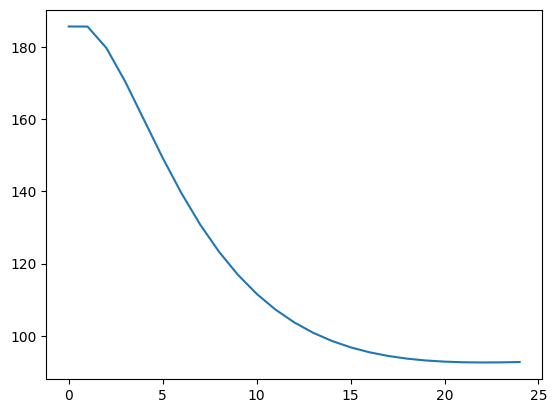

[75] loss: 0.001


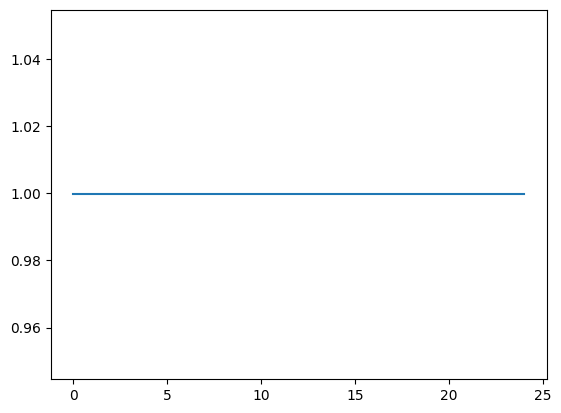

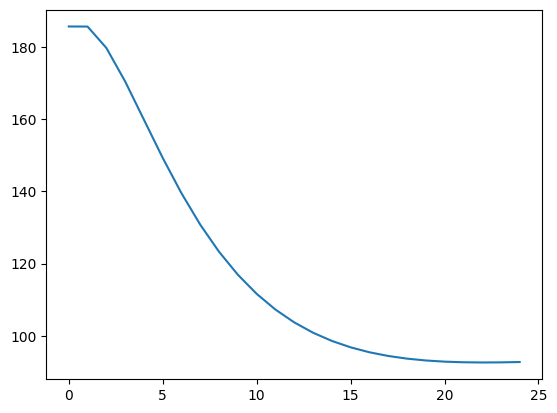

[76] loss: 0.001


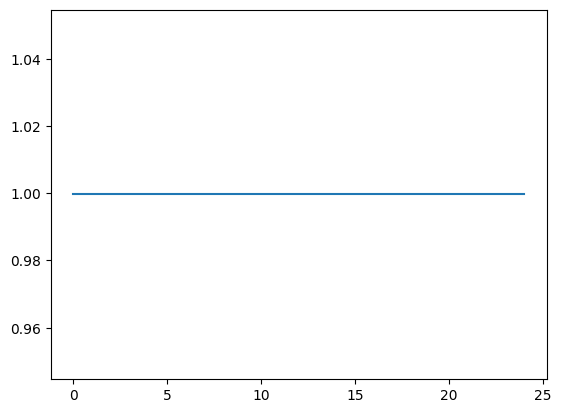

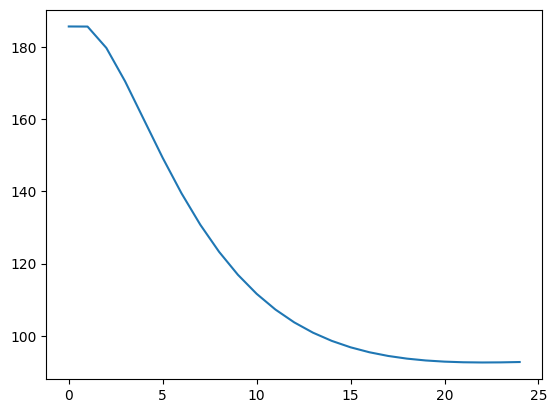

[77] loss: 0.001


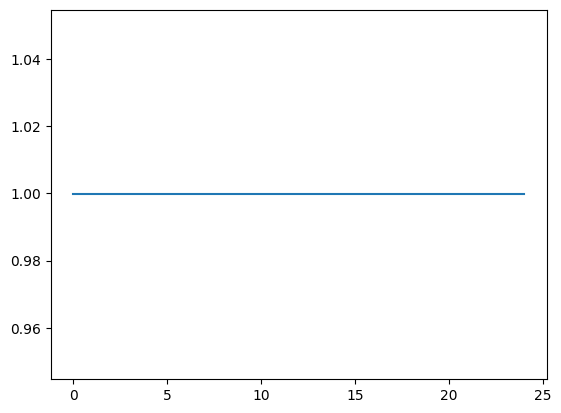

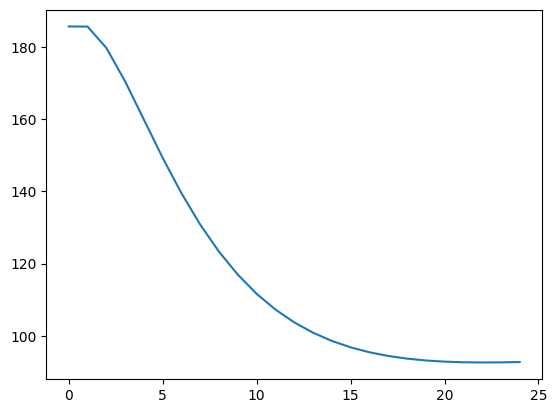

[78] loss: 0.001


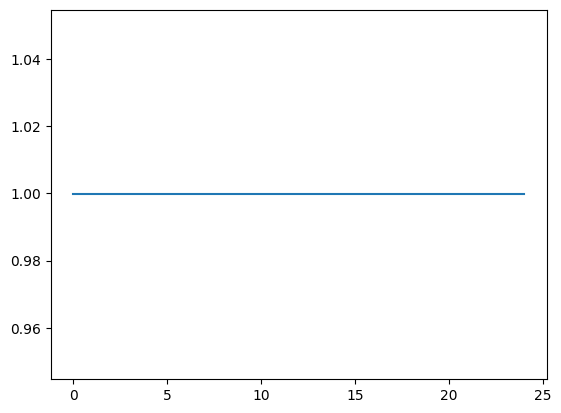

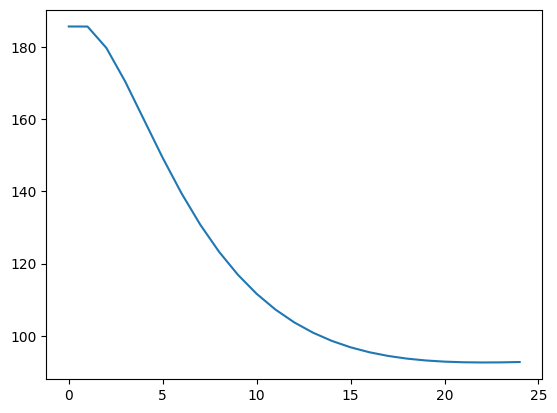

[79] loss: 0.001


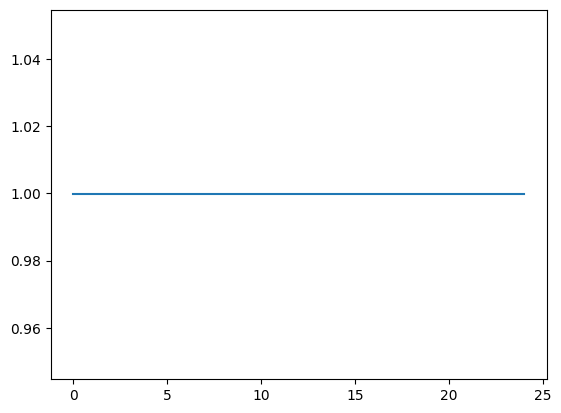

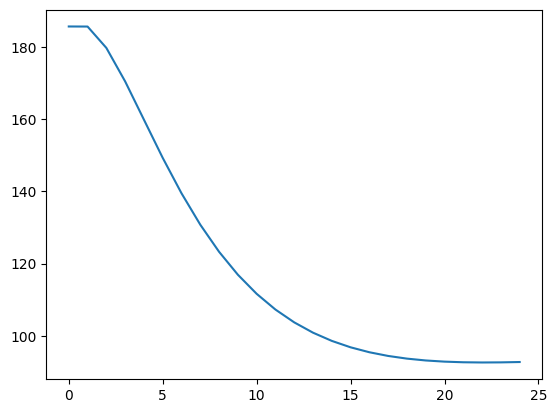

[80] loss: 0.001


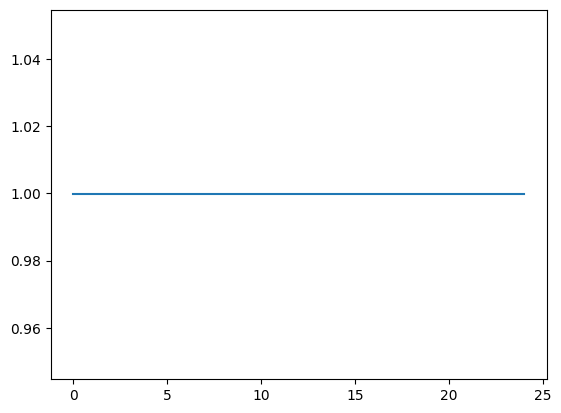

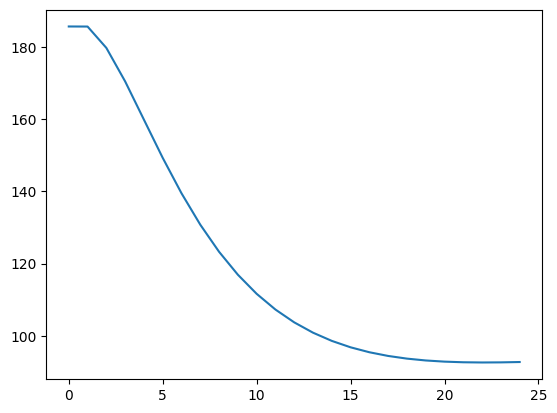

In [332]:
# Now it's time to run the code!

T = 25  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 8  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(80)  # solve the optimization problem

In [ ]:


state_tra